In [1]:
%matplotlib nbagg
import sys
import matplotlib.pyplot as plt
import qcodes as qc
import numpy as np
#import instrument
import qcodes.instrument_drivers.rohde_schwarz.ZNB as ZNB

from qcodes.dataset.measurements import Measurement
from qcodes.dataset.plotting import plot_by_id, load_by_id
from qcodes import new_experiment, Station, Instrument
from qcodes.dataset.data_export import get_data_by_id
from qcodes import Parameter

In [2]:
import reload
reload(qcodes)

ModuleNotFoundError: No module named 'reload'

# initialize database

In [4]:
#initialize database
import datetime
dataset_name = 'ABS_W1_5_1_1'
qc.config["core"]["db_location"] = datetime.date.today().strftime(r'D:\OneDrive\BF3\Data\%Y%m%d_'+dataset_name+'.db')
# automatically uses a different DB file for each month
qc.dataset.database.initialise_database()
qc.config.core.db_location

Upgrading database: : 0it [00:00, ?it/s]


'D:\\OneDrive\\BF3\\Data\\20190607_ABS_W1_5_1_1.db'

In [5]:
station = qc.Station()

In [6]:
exp = qc.new_experiment("Andreev spectroscopy", sample_name="ABS W1 #5(1,1)")

# Bluefors fridge log tunnel

## Bluefors log opening


In [7]:
#set the path here of the shared desktop file
BF_PC_PATH = '\\\\MININT-ETA6HHA\\Desktop\\BF Log Files\\' 

import time

<IPython.core.display.Javascript object>


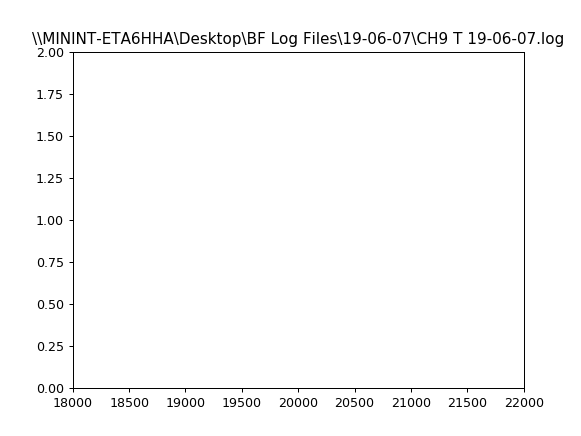

<IPython.core.display.Javascript object>


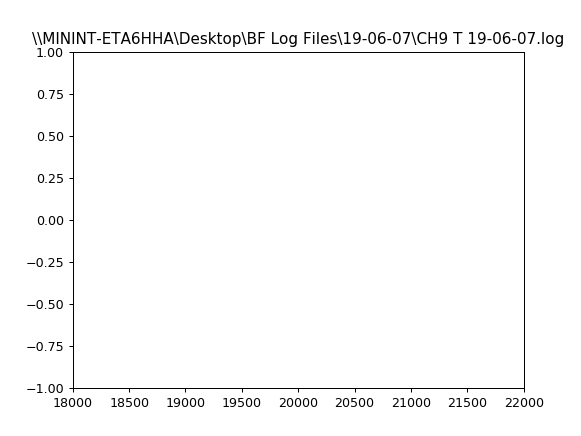

(-1, 1)

In [8]:
logfile_name = 'CH5 T'
days_in_the_past = 0
ts = datetime.datetime.today() - datetime.timedelta(days=days_in_the_past)
ds = '%02d-%02d-%02d'%(ts.year-2000, ts.month, ts.day) 
pth = BF_PC_PATH + ds + '\\' + logfile_name+ ' ' + ds+'.log'

T = np.loadtxt(pth, usecols = (2), delimiter = ',')
plt.figure()
plt.plot(T)
plt.title(ds + ' ' + pth)
plt.xlim(18000, 22000)
logfile_name = 'CH9 T'
ts = datetime.datetime.today() - datetime.timedelta(days=days_in_the_past)
ds = '%02d-%02d-%02d'%(ts.year-2000, ts.month, ts.day) 
pth = BF_PC_PATH + ds + '\\' + logfile_name+ ' ' + ds+'.log'
T1 = T
T = np.loadtxt(pth, usecols = (2), delimiter = ',')
#plt.figure()
plt.plot(T)
plt.title(pth)
plt.xlim(18000,22000)
plt.ylim((0,2))

plt.figure()
plt.plot(T1-T)
plt.title(pth)
plt.xlim(18000,22000)
plt.ylim((-1,1))

In [ ]:
import csv
BF_PC_PATH = '\\\\MININT-ETA6HHA\\Desktop\\BF Log Files\\' 

#code to get the timestamp copied here from the thermometer class

logfile_name = 'maxigauge'
days_in_the_past = 0
ts = datetime.datetime.today() - datetime.timedelta(days=days_in_the_past)
ds = '%02d-%02d-%02d'%(ts.year-2000, ts.month, ts.day) 
pth = BF_PC_PATH + ds + '\\' + logfile_name+ ' ' + ds+'.log'

file_list = []
with open(pth) as csvFile:
    reader = csv.reader(csvFile)
    for row in reader:
        #print(row)
        file_list.append(row)
csvFile.close()

#
print(file_list[0])
times = [file_list[i][1] for i in range(len(file_list))]
Ps = []
for k in range(0,6):
    Ps.append(np.array([float(file_list[i][5+k*6]) for i in range(len(file_list))]))

i_start = 0
i_stop = -1
for k in range(len(Ps)):
    plt.figure()
    plt.plot(times[i_start:i_stop], Ps[k][i_start:i_stop])
    plt.ylabel('Pressure (mBar)')
    plt.xlabel('Timestamp')
    plt.title('P%d at ' % (k+1) + ds )
    

## Thermometer using BF logs

In [9]:
#set the path here of the shared desktop file
from pytopo.sweep import sweep, measure, nest, chain, szip, getter, setter, time_trace, do_experiment
from pytopo.qctools.instruments import create_inst

class Thermometer(Instrument):
    
    def __init__(self, name, logfile_path, **kw):
        super().__init__(name, **kw)        
        self.add_parameter('temperature', get_cmd=self._get_temperature, set_cmd=None, unit='K')
        
        self.add_parameter('counter', get_cmd=self._counter, set_cmd=None, unit='')
        self._ind = 0
        print('Path of network drive(set this manually dear USER): ', logfile_path)
        self.logfile_path = logfile_path
        
    def _counter(self):
        self._ind += 1
        return self._ind
    def _get_temperature(self):
        ts = datetime.datetime.today()
        ds = '%02d-%02d-%02d'%(ts.year-2000, ts.month, ts.day)
        pth = self.logfile_path + ds + '\\CH9 T '+ds+'.log'
        time.sleep(0.1)
        try:
            T = np.loadtxt(pth, usecols = (2), delimiter = ',')[-1]
        except: # in the first few seconds of a day, a new log file hasn't been created
            ts = datetime.datetime.today() - datetime.timedelta(days=1) # use the last entry in the previous day
            ds = '%02d-%02d-%02d'%(ts.year-2000, ts.month, ts.day)
            pth = self.logfile_path + ds + '\\CH9 T '+ds+'.log'
            T = np.loadtxt(pth, usecols = (2), delimiter = ',')[-1]
        return T
    
        
    
T_probe = create_inst(Thermometer, 'T_probe', logfile_path=BF_PC_PATH, force_new_instance=True)
T_probe.temperature()



Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\


0.024025299999999999

In [11]:
BF_PC_PATH = '\\\\MININT-ETA6HHA\\Desktop\\BF Log Files\\'
ds = '%02d-%02d-%02d'%(ts.year-2000, ts.month, ts.day)
pth = BF_PC_PATH+ ds + '\\CH9 T '+ds+'.log'

# VNA measurements of lines.
https://github.com/QCoDeS/Qcodes/blob/master/docs/examples/driver_examples/Qcodes%20example%20with%20Rohde%20Schwarz%20ZNB.ipynb 

In [10]:
vna = create_inst(ZNB.ZNB, "VNA", 'USB0::0x0AAD::0x01A1::101879::INSTR', force_new_instance=True, init_s_params=False)
#station.remove_component(vna)
station.add_component(vna)
# the channel we want to measure. we set init_s_params false to not have to measure all channels, thus saving time 
channel_name = 'S21' ##Now we add a channel S12: Since the HEMT is connected to port 1. 
vna.add_channel(channel_name)


Connected to: Rohde-Schwarz ZNB20-2Port (serial:1311601062101879, firmware:2.86) in 0.63s


In [13]:
 meas = Measurement()

In [12]:
import time
import numpy as np
def do_single_sweep(n_pts = 10000, f_start = 3.2e9, f_stop = 6.5e9, power=-60, n_avg=10, channel_name='S12',
                   extra_params = []):
    """
    extra_params expects [(qcodes.Parameter, value)...]
    """

    # let's set the trace properties. 
    trace = getattr(vna.channels, channel_name)
    trace.avg(n_avg)
    trace.npts(n_pts)
    trace.power(power)
    trace.start(f_start)
    trace.stop(f_stop)
    vna.rf_on()
    
    
    #now setup the qcodes measurement object
    meas = Measurement()
    #meas.register_parameter(temperature, setpoints=['time',])
    #meas.register_parameter(temperature_sample, setpoints=['time',])
    meas.register_custom_parameter('frequency', unit='Hz',
                                   paramtype='array')
    meas.register_custom_parameter('time', unit='s', paramtype='numeric')
    meas.register_custom_parameter('power', unit='dBm', setpoints=['time'])
    meas.register_custom_parameter('magnitude_dB', unit='dB', 
                                    setpoints=['frequency'],
                                   paramtype='array'),
    meas.register_custom_parameter('magnitude_raw', unit='V', 
                                   setpoints=['frequency'],
                                   paramtype='array')
    meas.register_custom_parameter('phase', unit='rad', 
                                   setpoints=[ 'frequency'],
                                   paramtype='array')
    
    #any custom params that someone wants to save as well in the measuremebt
    for param in extra_params:
        meas.register_parameter(param[0])
    
    with meas.run() as datasaver:
        fvals = np.linspace(trace.start(), trace.stop(), trace.npts())
        mag, phase = trace.trace_mag_phase()
        mag_db = 20*np.log10(mag) #convert to dB
        result = [ ('time', time.time()),
           # (temperature, temperature()),
           # (temperature_sample, temperature_sample()),
            ('frequency', fvals),
            ('magnitude_raw', mag),
            ('magnitude_dB',mag_db ),
            ('phase', phase),
            ('power', power)]
        result.extend(extra_params)
        datasaver.add_result(
            *result
           )
    return datasaver.run_id


def do_single_sweep_with_temperature(n_pts = 10000, f_start = 3.2e9, f_stop = 6.5e9, power=-60, n_avg=10, channel_name='S12'):

    """
    Saves a timestamp and a temperature. 
    """
    #first try to get temperature:
    T_probe = create_inst(Thermometer, 'T_probe', logfile_path=BF_PC_PATH, force_new_instance=True)
    temperature = T_probe.temperature()
    
    # let's set the trace properties. 
    trace = getattr(vna.channels, channel_name)
    trace.avg(n_avg)
    trace.npts(n_pts)
    trace.power(power)
    trace.start(f_start)
    trace.stop(f_stop)
    vna.rf_on()
    
    #now setup the qcodes measurement object
    meas = Measurement()
    #meas.register_parameter(temperature, setpoints=['time',])
    #meas.register_parameter(temperature_sample, setpoints=['time',])
    meas.register_custom_parameter('frequency', unit='Hz',
                                   paramtype='array')
    meas.register_custom_parameter('time', unit='s', paramtype='numeric')
    meas.register_custom_parameter('temperature', unit='K', paramtype='numeric', setpoints=['time'])
    meas.register_custom_parameter('power', unit='dBm', setpoints=['time'])
    meas.register_custom_parameter('magnitude_dB', unit='dB', 
                                    setpoints=['frequency'],
                                   paramtype='array'),
    meas.register_custom_parameter('magnitude_raw', unit='V', 
                                   setpoints=['frequency'],
                                   paramtype='array')
    meas.register_custom_parameter('phase', unit='rad', 
                                   setpoints=[ 'frequency'],
                                   paramtype='array')
    
    with meas.run() as datasaver:
        fvals = np.linspace(trace.start(), trace.stop(), trace.npts())
        mag, phase = trace.trace_mag_phase()
        mag_db = 20*np.log10(mag) #convert to dB
        result = [ ('time', time.time()),
           # (temperature, temperature()),
           # (temperature_sample, temperature_sample()),
            ('frequency', fvals),
            ('magnitude_raw', mag),
            ('magnitude_dB',mag_db ),
            ('phase', phase),
            ('power', power),
            ('temperature', temperature)]
        datasaver.add_result(
            *result
           )
    return datasaver.run_id

In [24]:
power_levels = list(range(5,15,5))
res_freqs = [3.535e9, 4.020e9, 4.847e9, 5.889e9]
df = 0.1e9

for power in power_levels:   
    for freq in res_freqs:
        print(freq-df)
        print(freq+df)
        print(power)
        run_id = do_single_sweep_with_temperature(n_pts = 30000, f_start = freq-df, f_stop = freq+df,
                                                  power=power, n_avg=30, channel_name=channel_name)
        
        
        


3435000000.0
3635000000.0
5
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\
Starting experimental run with id: 5
3920000000.0
4120000000.0
5
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\
Starting experimental run with id: 6


KeyboardInterrupt: 

In [41]:
run_id = do_single_sweep_with_temperature(n_pts = 30000, f_start = 3e9, f_stop = 10e9,
                                                  power=-20, n_avg= 100, channel_name='S21')

Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\
Starting experimental run with id: 11


<IPython.core.display.Javascript object>


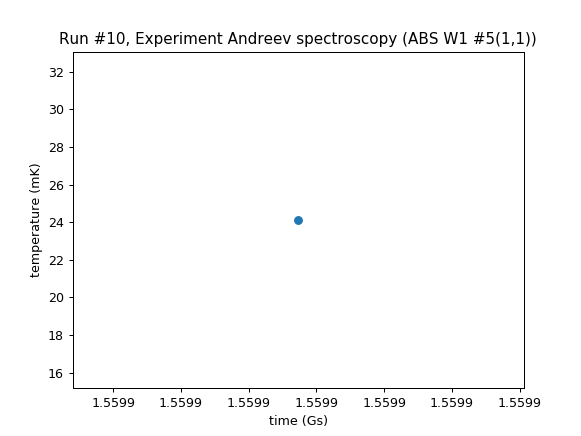

<IPython.core.display.Javascript object>


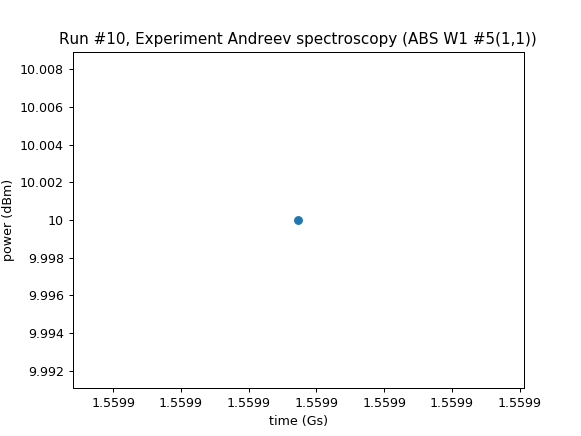

<IPython.core.display.Javascript object>


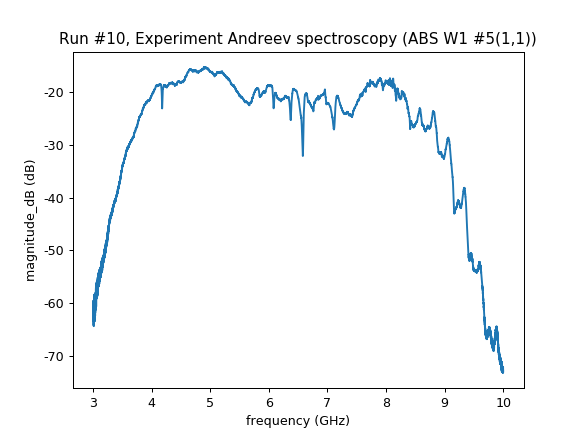

<IPython.core.display.Javascript object>


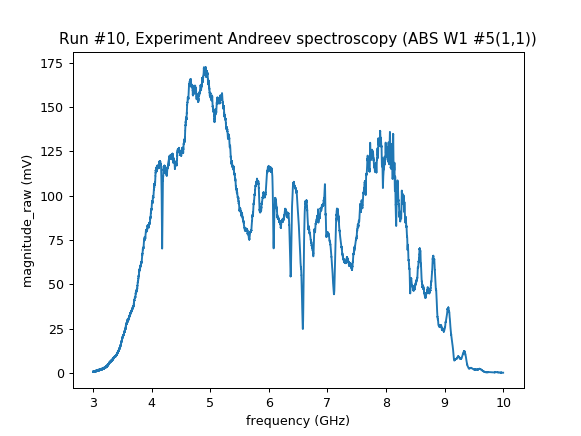

<IPython.core.display.Javascript object>


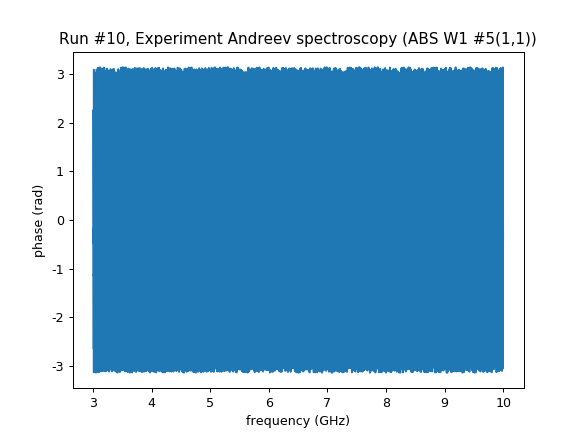

In [39]:
aves, bla = plot_by_id(run_id)

<IPython.core.display.Javascript object>


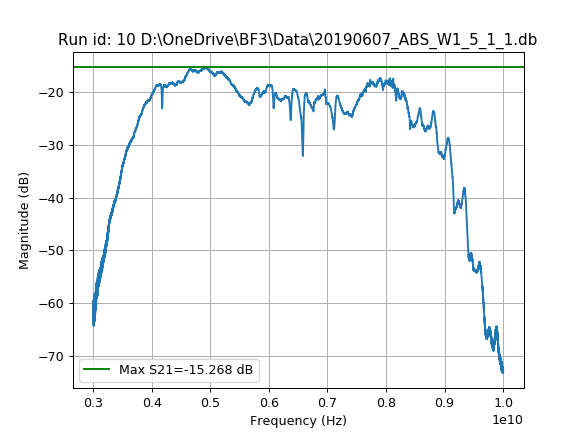

Text(0,0.5,'Magnitude (dB)')

In [43]:
run_id=10
dat=load_by_id(run_id)
freqs = np.squeeze(dat.get_data('frequency'))
mag_db = np.squeeze(dat.get_data('magnitude_dB'))

plt.figure()
plt.plot(freqs,mag_db)
plt.grid()
plt.title('Run id: %d %s' %(run_id, qc.config["core"]["db_location"]))
plt.axhline(y = np.max(mag_db), label='Max S21=%.3f dB' % np.max(mag_db), color='g')
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
#plt.xlim(4e9,8e9)

In [34]:
vna.rf_off()

In [ ]:
meas = Measurement()
vna.channels.S12.format('dB')
meas.register_parameter(vna.channels.S12.trace)
with meas.run() as datasaver:
    get_v = vna.channels.S12.trace.get()
    datasaver.add_result((vna.channels.S12.trace, get_v))
ax, cbax = plot_by_id(datasaver.run_id)

## 2 D sweeps: power 

In [ ]:
def do_2d_power_sweep(powers=[],n_pts = 10000, f_start = 3.2e9, f_stop = 6.5e9, n_avg=10, channel_name='S12'):

    """
. 
    """
    #first try to get temperature:
    T_probe = create_inst(Thermometer, 'T_probe', logfile_path=BF_PC_PATH, force_new_instance=True)
    temperature = T_probe.temperature()
    
    # let's set the trace properties. 
    channel = getattr(vna.channels, channel_name)
    
    channel.avg(n_avg)
    channel.npts(n_pts)
    channel.start(f_start)
    channel.stop(f_stop)
    channel.power(powers[0])
    channel.format('Complex')
    vna.rf_on()
    
    #now setup the qcodes measurement object
    meas = Measurement()
    meas.register_custom_parameter('temperature', unit='K', paramtype='numeric')
    #meas.register_parameter(temperature_sample, setpoints=['time',])
    meas.register_custom_parameter('frequency', unit='Hz',
                                   paramtype='array')
    meas.register_custom_parameter('power', unit='dBm'),
    meas.register_custom_parameter('Re_S', unit='V', 
                                    setpoints=['frequency','power'],
                                   paramtype='array'),
    meas.register_custom_parameter('Im_S', unit='V', 
                                   setpoints=['frequency', 'power'],
                                   paramtype='array')
    meas.register_custom_parameter('magnitude_dB', unit='dB', 
                                   setpoints=[ 'frequency', 'power'],
                                   paramtype='array')
    
    with meas.run() as datasaver:
        for power in powers:
            channel.power(power)
            fvals = np.linspace(channel.start(), channel.stop(), channel.npts())
            S12 = channel.trace.get()
            mag_db = 20*np.log10(np.abs(S12)) #convert to dB
            result = [ 
                ('frequency', fvals),
                ('Re_S', np.real(S12)),
                ('magnitude_dB',mag_db ),
                ('Im_S', np.imag(S12)),
                ('power', power),
                ('temperature', temperature)]
            datasaver.add_result(
                *result
               )
            print('done power %d' % power)
    return datasaver.run_id




In [ ]:
np.arange(-30,16, 1)

In [ ]:
res_freqs = [3.535e9, 4.020e9, 4.847e9, 5.889e9]
df = 0.02e9
  
for freq in res_freqs:
    print(freq-df)
    print(freq+df)
    run_id_1 = do_2d_power_sweep(powers=np.arange(-20,15, 5),n_pts = 2000, f_start = freq-df, f_stop = freq+df, n_avg=500, channel_name='S12')
vna.rf_off()

In [ ]:
data = load_by_id(23)
freqs = np.squeeze(np.array(data.get_data('frequency')))
powers = np.squeeze(np.array(data.get_data('power')))
mag = np.squeeze(np.array(data.get_data('magnitude_dB')))
plt.figure()
plt.plot(freqs.T,mag.T, 'x')

In [ ]:
vna.rf_off()

In [ ]:
do_2d_power_sweep(powers=np.arange(-40,0, 5),n_pts = 30000, f_start = 2.9e9, f_stop = 12e9, n_avg=50, channel_name='S12')

## Temperature sweep

In [ ]:
def do_2d_T_sweep(T_max = 20, power = -20,n_pts = 10000, f_start = 3.2e9, f_stop = 6.5e9, n_avg=10, channel_name='S12'):

    """
. 
    """

    # let's set the trace properties. 
    channel = getattr(vna.channels, channel_name)
    
    channel.avg(n_avg)
    channel.npts(n_pts)
    channel.start(f_start)
    channel.stop(f_stop)
    channel.power(power)
    channel.format('Complex')
    vna.rf_on()
    
    #now setup the qcodes measurement object
    meas = Measurement()
    meas.register_custom_parameter('temperature', unit='K', paramtype='numeric')
    #meas.register_parameter(temperature_sample, setpoints=['time',])
    meas.register_custom_parameter('frequency', unit='Hz',
                                   paramtype='array')
    meas.register_custom_parameter('power', unit='dBm'),
    meas.register_custom_parameter('Re_S', unit='V', 
                                    setpoints=['frequency','temperature'],
                                   paramtype='array'),
    meas.register_custom_parameter('Im_S', unit='V', 
                                   setpoints=['frequency', 'temperature'],
                                   paramtype='array')
    meas.register_custom_parameter('magnitude_dB', unit='dB', 
                                   setpoints=[ 'frequency', 'temperature'],
                                   paramtype='array')
    
    with meas.run() as datasaver:
      #first try to get temperature:
        T_probe = create_inst(Thermometer, 'T_probe', logfile_path=BF_PC_PATH, force_new_instance=True)
        temperature = T_probe.temperature()
        while temperature <  T_max:
            T_probe = create_inst(Thermometer, 'T_probe', logfile_path=BF_PC_PATH, force_new_instance=True)
            temperature = T_probe.temperature()
            
            fvals = np.linspace(channel.start(), channel.stop(), channel.npts())
            S12 = channel.trace.get()
            mag_db = 20*np.log10(np.abs(S12)) #convert to dB
            result = [ 
                ('frequency', fvals),
                ('Re_S', np.real(S12)),
                ('magnitude_dB',mag_db ),
                ('Im_S', np.imag(S12)),
                ('power', power),
                ('temperature', temperature)]
            datasaver.add_result(
                *result
               )
            print('done T=%.3f' % temperature)
    return datasaver.run_id




In [ ]:
do_2d_T_sweep(power=20,T_max=20, n_pts = 5000, f_start = 2.5e9, f_stop = 10e9, n_avg=5, channel_name='S12')

# MDac

In [ ]:
sys.path.append(r"D:\OneDrive\BF3\Code");
sys.path.append(r"D:\OneDrive\BF3\Code\labtools-master")
sys.path.append(r"D:\OneDrive\BF3\Code\StationQ\MDAC\Driver")
from MDAC import MDAC
from pytopo.sweep import sweep, measure, nest, chain, szip, getter, setter, time_trace, do_experiment
from pytopo.qctools.instruments import create_inst


mdac = MDAC('MDAC', 'ASRL4::INSTR', debug=False, logging=False)

station.add_component(mdac)

In [ ]:
station.add_component(mdac)

## MDAC helper functions

In [ ]:
gate_ramp_stepsize = 1e-3  #[V] previously was 1e-3
gate_ramp_delay = 0.01  #[s]

def initialize(*channels):
    for s in channels:
        ramp(s.voltage, 0, gate_ramp_stepsize, gate_ramp_delay)
    #     ramp(g.voltage, 0, gate_ramp_stepsize, gate_ramp_delay)
        s.smc('close')
        s.dac_output('close')
    #     d.gnd('close')
    #     g.dac_output('close')
    #     g.smc('close')
    
def initialize_leakage(channels_to_close, channels_to_open):
    for s in channels_to_close:
        ramp(s.voltage, 0, gate_ramp_stepsize, gate_ramp_delay)
        s.smc('close')
        s.dac_output('close')
    for s in channels_to_open:
        ramp(s.voltage, 0, gate_ramp_stepsize, gate_ramp_delay)
        s.smc('open')
        s.dac_output('open')
        
        


def ramp(param, target, step_size, delay): 
    current_value = param()
    step_size *= np.sign(target - current_value)
    if abs(step_size) < 1E-10: 
        return 
    
    steps = np.arange(current_value, target, step_size)
    for step in steps: 
        param(step)
        time.sleep(delay)
    
    param(target)
    
def set_mdac_in_safemode(nchan=64):
    #ivvi.dac1(0)
    #ivvi.dac3(0)
    #lockin1.amplitude(0)
    #lockin1.sine_outdc(0)
    
    print('setting mdac in safe mode')
    
    for ch in mdac.channels[:nchan]:
        ramp(ch.voltage, 0, gate_ramp_stepsize, gate_ramp_delay)

    # Note: we do this in separate loops because we want to be sure that
    # no currents are running anywhere before switching the relays
    for ch in mdac.channels[:nchan]:
        ch.dac_output('open')
        ch.bus('open')
        ch.gnd('open')
        ch.smc('open')
        ch.microd('open')
        #ch.divider('off')
    print('Done')

def chs_safe(*channels):
    lockin1.amplitude(0)
    lockin1.sine_outdc(0)   
    print('setting mdac in safe mode')
    for ch in channels:
        ramp(ch.voltage, 0, gate_ramp_stepsize, gate_ramp_delay)
        ch.dac_output('open')
        ch.bus('open')
        ch.gnd('open')
        ch.smc('open')
        ch.microd('open')
    print('Done')
    
    
    
### added function by jaap

def print_voltage_current(channel):
    voltage = channel.voltage()
    gain = 1e6
    key_raw1 = key1.volt()
    current_dc1 = -key_raw1/gain
    print('raw v key 1' ,key_raw1)
    print('current_dc1', current_dc1)
    print('voltage: ', voltage)

### MDAC channel definition

In [ ]:
MDAC_channels = {
    'A' : {
        'V_pl_A' : mdac.ch02,
        'V_cut_A' : mdac.ch01,
        'V_pr_A' : mdac.ch03,
        'V_bot_A' : mdac.ch04
    },
    'B' : {
        'V_pl_B' : mdac.ch09,
        'V_cut_B' : mdac.ch10,
        'V_pr_B' : mdac.ch11,
        'V_bot_B' : mdac.ch01
    },
    'C' : {
        'V_pl_C' : mdac.ch25,
        'V_cut_C' : mdac.ch26,
        'V_pr_C' : mdac.ch09,
        'V_bot_C' : mdac.ch27
    },
    'D' : {
        'V_pl_D' : mdac.ch41,
        #'V_cut' : mdac.ch01, cutter doesnt exist in D
        'V_pr_D' : mdac.ch42,
        'V_bot_D' : mdac.ch25
    }
}


## MDAC gate testing

In [ ]:
set_mdac_in_safemode()

In [ ]:
mdac.ch01.voltage()

In [ ]:
#initialize all channels:

for res in MDAC_channels:
    for chan in MDAC_channels[res]:
        print("Initializing %s %s %s" % (res,chan, MDAC_channels[res][chan]))
        initialize(MDAC_channels[res][chan])

## class def

In [ ]:
class CustomInstrument(Instrument):
    
    def add_params_to_measurement(measurement):
        for 
    
class VNASweep(CustomInstrument):
    
    def __init__(self, name, **kw):
        super().__init__(name, **kw)        
        self.add_parameter('mag', get_cmd=None, set_cmd=None, paramtype='array', unit='V')
        self.add_parameter('phase', get_cmd=None, set_cmd=None, paramtype='array', unit='rad')
        self.add_parameter('magnitude_dB', get_cmd=None, set_cmd=None, paramtype='array', unit='dB')
        self.add_parameter('Re_S',  get_cmd=None, set_cmd=None, paramtype='array', unit='V')
        self.add_parameter('Im_S',  get_cmd=None, set_cmd=None, paramtype='array', unit='V')
        self.add_parameter('frequency', get_cmd=None,set_cmd=None, paramtype='array')

vnasweep = VNASweep('VNA_sweep')

# Magnet 

Check that the magnet is the "right" one and so the parameters (coil constant and so on...)

In [ ]:
from qcodes.instrument_drivers.american_magnetics.AMI430 import AMI430,AMI430_3D
from pytopo.qctools import instruments as instools


In [271]:
ami_x = instools.create_inst(AMI430, "AMI430_x", "169.254.178.28", port = 7180, has_current_rating=True)
#ami_y = instools.create_inst(AMI430, "AMI430_y", "169.254.175.39", port = 7180, has_current_rating=True)
ami_z = instools.create_inst(AMI430, "AMI430_z", "169.254.137.107", port = 7180, has_current_rating=True)

ramp_limit_multiplier = 0.6
ami_x.current_ramp_limit(0.1805*ramp_limit_multiplier) #for QT3 magnet 0.1802
ami_x.coil_constant(0.01464)  #for QT3 magnet 0.01466
ami_x.current_rating(68.31)  #for QT3 magnet 68.21

#ami_y.current_ramp_limit(0.1810*ramp_limit_multiplier) #for QT3 magnet 0.1784
#ami_y.coil_constant(0.01477) #for QT3 magnet 0.01464
#ami_y.current_rating(67.7) #for QT3 magnet 68.31

ami_z.current_ramp_limit(0.0760*ramp_limit_multiplier) #for QT3 magnet 0.0775
ami_z.coil_constant(0.0836)  #for QT3 magnet 0.0818
ami_z.current_rating(71.77)  #for QT3 magnet 73.35

#ami = instools.create_inst(AMI430_3D, "AMI430", ami_x, ami_y, ami_z, 2)
#ami_3d = AMI430_3D("AMI_3D", ami_x, ami_y, ami_z, 1);

Instrument AMI430_x already exists.
Instrument AMI430_z already exists.


d:\onedrive\bf3\code\qcodes\qcodes\instrument_drivers\american_magnetics\AMI430.py:407: AMI430Warning: Increasing maximum ramp rate: we have a default current ramp rate limit of 0.1 A/s. We do not want to ramp faster than a set maximum so as to avoid quenching the magnet. A value of 0.1 A/s seems like a safe, conservative value for any magnet. Change this value at your own responsibility after consulting the specs of your particular magnet
  warn(warning_message, category=AMI430Warning)


In [272]:
print(ami_x.ramp_rate(), 'T/ ramp rate unit')
#print(ami_y.ramp_rate())
print(ami_z.ramp_rate())
print(ami_x.ramp_rate_units())
print(ami_z.current_ramp_limit())
#30.1802*ramp_limit_multiplier
print(ami_x.field())
#print(ami_y.field())
print(ami_z.field())
print (ami_3d.field_measured())
print(ami_3d.phi_measured())

0.000499318 T/ ramp rate unit
0.001
seconds
0.045599999999999995
6.4e-06
0.6000388


NameError: name 'ami_3d' is not defined

In [ ]:
ami_y.ramp_rate(0.1e-3)

In [ ]:
#note that 0.01 mT is already fluctuating between 
ami_y.field(0)

In [ ]:
set_yoko_field(0.1e-4)

## Yoko current source for y axis

In [ ]:
from qcodes.instrument_drivers.yokogawa.GS200 import GS200
yoko1 = create_inst(GS200,"yoko1", "USB0::0x0B21::0x0039::91T926460::INSTR", force_new_instance=True)
station.add_component(yoko1)
#yoko1.off()

In [ ]:
yoko1.off()

In [ ]:
yoko1.current_limit(200e-3)
yoko1.source_mode("CURR")
yoko1.on()
yoko1.auto_range(True)
yoko1.current()
#yoko1.current(0)


In [ ]:
def set_yoko_field(field_strength, current_rating= 67.7, #QT2 current rating y-axis magnet. 
                  yoko_ramp_step = 1e-7, # in A
                  yoko_ramp_delay = 1e-6): # in s):
    """
    goes as 67.7A/T
    """
    amp = field_strength * current_rating
    if(np.abs(amp) > 200e-3):
        raise Exception("Required current for field beyond yoko limit")
    
    yoko1.ramp_current(amp, yoko_ramp_step, yoko_ramp_delay)
def get_yoko_field(current_rating= 67.7):
    """
    returns the field in Tesla
    """
    return yoko1.current() / current_rating 
print(get_yoko_field())


class YokoMagnet(Instrument):
    """
    Just a class to do 3D magnet stuff but then with the yoko as y-axis instead of ami-y
    """    
    def __init__(self, name, ami_x, ami_z, **kwargs):
        super().__init__(name, **kwargs)
        
        #use the ami x and z params
        self.add_parameter('z', get_cmd=ami_z.field, set_cmd=ami_z.field, unit='T')
        self.add_parameter('x', get_cmd=ami_x.field, set_cmd=ami_x.field, unit='T')
        #but define custom function for y
        self.add_parameter('y', get_cmd=get_yoko_field, set_cmd=set_yoko_field, unit='T')
    
    def transform_spherical_to_cartesian(self, r, theta, phi):
        """
        Does what it sais, uses the same convention as FieldVector QCodes math helper function and thus as the AMI_3D driver
        note radians...
        """
        z = r * np.cos(theta)
        x = r * np.sin(theta) * np.cos(phi)
        y = r * np.sin(theta) * np.sin(phi)
        return x, y, z

In [ ]:
yoko_magnet = create_inst(YokoMagnet, 'yoko_magnet',ami_x = ami_x,ami_z = ami_z, force_new_instance=True)
station.add_component(yoko_magnet)

In [240]:
yoko_magnet.z(0)
yoko_magnet.x(0)
yoko_magnet.y(0)

## 2D gate frequency sweeps

In [ ]:
def do_gate_resonator_sweep(gate_channel, gate_voltages,gate_name='V_g',
                            gate_ramp_stepsize = 1e-3,  #[V] previously was 1e-3
                            gate_ramp_delay = 0.01 , #[s]
                            power=-30, n_pts = 10000, f_start = 3.2e9, f_stop = 6.5e9, n_avg=10, channel_name='S12'):

    """
   
    """
    #check the gate voltage
    print("Starting voltage", gate_channel.voltage())
    
    
    
    #first try to get temperature:
    T_probe = create_inst(Thermometer, 'T_probe', logfile_path=BF_PC_PATH, force_new_instance=True)
    temperature = T_probe.temperature()
    
    # let's set the trace properties. 
    vna_channel = getattr(vna.channels, channel_name)
    
    vna_channel.avg(n_avg)
    vna_channel.npts(n_pts)
    vna_channel.start(f_start)
    vna_channel.stop(f_stop)
    vna_channel.power(power)
    vna_channel.format('Complex')
    vna.rf_on()
    
    #now setup the qcodes measurement object
    meas = Measurement()
    meas.register_custom_parameter('temperature', unit='K', paramtype='numeric')
    #meas.register_parameter(temperature_sample, setpoints=['time',])
    meas.register_custom_parameter('frequency', unit='Hz',
                                   paramtype='array')
    meas.register_custom_parameter(gate_name, unit='V'),
    meas.register_custom_parameter('power', unit='dBm'),
    meas.register_custom_parameter('Re_S', unit='V', 
                                    setpoints=['frequency',gate_name],
                                   paramtype='array'),
    meas.register_custom_parameter('Im_S', unit='V', 
                                   setpoints=['frequency', gate_name],
                                   paramtype='array')
    meas.register_custom_parameter('mag', unit='V', 
                                   setpoints=['frequency', gate_name],
                                   paramtype='array')
    meas.register_custom_parameter('phase', unit='V', 
                                   setpoints=['frequency', gate_name],
                                   paramtype='array')
    meas.register_custom_parameter('magnitude_dB', unit='dB', 
                                   setpoints=[ 'frequency', gate_name],
                                   paramtype='array')
    
    with meas.run() as datasaver:
        for gate_voltage in gate_voltages:
            
            #ramp the gate voltage
            print("Ramping %s to %.2e" % (gate_name, gate_voltage))
            ramp(gate_channel.voltage, gate_voltage, gate_ramp_stepsize, gate_ramp_delay )
            print("Done ramping")
            fvals = np.linspace(vna_channel.start(), vna_channel.stop(), vna_channel.npts())
            S12 = vna_channel.trace.get()
            mag_db = 20*np.log10(np.abs(S12)) #convert to dB
            result = [ 
                ('frequency', fvals),
                ('Re_S', np.real(S12)),
                ('magnitude_dB',mag_db ),
                ('Im_S', np.imag(S12)),
                ('phase', np.angle(S12)),
                ('mag', np.abs(S12)),
                ('power', power),
                (gate_name, gate_voltage),
                ('temperature', temperature)]
            datasaver.add_result(
                *result
               )
            print('done power %d' % power)
    return datasaver.run_id




def do_multiple_gate_resonator_sweep(
                            gate_channel, gate_voltages,gate_name='V_g',
                            gate_ramp_stepsize = 1e-3,  #[V] previously was 1e-3
                            gate_ramp_delay = 0.01 , #[s]
                            power=-30, n_pts = 10000, f_start = 3.2e9, f_stop = 6.5e9, n_avg=10, channel_name='S12'):

    """
   
    """
    if not isinstance(gate_channel, list):
        gate_channel = [gate_channel] #allow for multple gates to be swept at once. 
        if not isinstance(gate_name, list):
            gate_name = [gate_name]
        else:
            raise Exception('Either give both gate channel and gate name as a list or both as a value..')
    
    #check the gate voltage
    for chan in gate_channel:
        print(chan,chan.voltage())
    
    #set the gate name to be all gates together
    long_gate_name = ''
    for name in gate_name:
        long_gate_name += name + '_' #make one variable out of multiple gates snce they are swept together
    
    #first try to get temperature:
    T_probe = create_inst(Thermometer, 'T_probe', logfile_path=BF_PC_PATH, force_new_instance=True)
    temperature = T_probe.temperature()
    
    # let's set the trace properties. 
    vna_channel = getattr(vna.channels, channel_name)
    
    vna_channel.avg(n_avg)
    vna_channel.npts(n_pts)
    vna_channel.start(f_start)
    vna_channel.stop(f_stop)
    vna_channel.power(power)
    vna_channel.format('Complex')
    vna.rf_on()
    
    #now setup the qcodes measurement object
    meas = Measurement()
    meas.register_custom_parameter('temperature', unit='K', paramtype='numeric')
    #meas.register_parameter(temperature_sample, setpoints=['time',])
    meas.register_custom_parameter('frequency', unit='Hz',
                                   paramtype='array')
    meas.register_custom_parameter(long_gate_name, unit='V'),
    meas.register_custom_parameter('power', unit='dBm'),
    meas.register_custom_parameter('Re_S', unit='V', 
                                    setpoints=['frequency',long_gate_name],
                                   paramtype='array'),
    meas.register_custom_parameter('Im_S', unit='V', 
                                   setpoints=['frequency', long_gate_name],
                                   paramtype='array')
    meas.register_custom_parameter('mag', unit='V', 
                                   setpoints=['frequency', long_gate_name],
                                   paramtype='array')
    meas.register_custom_parameter('phase', unit='V', 
                                   setpoints=['frequency', long_gate_name],
                                   paramtype='array')
    meas.register_custom_parameter('magnitude_dB', unit='dB', 
                                   setpoints=[ 'frequency', long_gate_name],
                                   paramtype='array')
    
    with meas.run() as datasaver:
        for gate_voltage in gate_voltages:
            
            #ramp the gate voltage
            for i in range(len(gate_channel)):
                print("Ramping %s to %.2e" % (gate_name[i], gate_voltage))
                ramp(gate_channel[i].voltage, gate_voltage, gate_ramp_stepsize, gate_ramp_delay )
                print("Done ramping")
            fvals = np.linspace(vna_channel.start(), vna_channel.stop(), vna_channel.npts())
            S12 = vna_channel.trace.get()
            mag_db = 20*np.log10(np.abs(S12)) #convert to dB
            result = [ 
                ('frequency', fvals),
                ('Re_S', np.real(S12)),
                ('magnitude_dB',mag_db ),
                ('Im_S', np.imag(S12)),
                ('phase', np.angle(S12)),
                ('mag', np.abs(S12)),
                ('power', power),
                (long_gate_name, gate_voltage),
                ('temperature', temperature)]
            datasaver.add_result(
                *result
               )
            print('done power %d' % power)
    return datasaver.run_id


def do_multiple_gate_multiple_resonator_sweep(
                            gate_channel, gate_voltages,gate_name='V_g',
                            f_starts = [3.2e9], f_stops = [6.5e9], f_names=['A'],
                            gate_ramp_stepsize = 1e-3,  #[V] previously was 1e-3
                            gate_ramp_delay = 0.01 , #[s]
                            power=-30, n_pts = 10000, n_avg=10, channel_name='S12'):

    """
   
    """
    if not isinstance(gate_channel, list):
        gate_channel = [gate_channel] #allow for multple gates to be swept at once. 
        if not isinstance(gate_name, list):
            gate_name = [gate_name]
        else:
            raise Exception('Either give both gate channel and gate name as a list or both as a value..')
    
    #check the gate voltage
    for chan in gate_channel:
        print(chan,chan.voltage())
    
    #set the gate name to be all gates together
    long_gate_name = ''
    for name in gate_name:
        long_gate_name += name + '_' #make one variable out of multiple gates snce they are swept together
    
    #first try to get temperature:
    T_probe = create_inst(Thermometer, 'T_probe', logfile_path=BF_PC_PATH, force_new_instance=True)
    temperature = T_probe.temperature()
    
    # let's set the trace properties. 
    vna_channel = getattr(vna.channels, channel_name)
    
    vna_channel.avg(n_avg)
    vna_channel.npts(n_pts)
    vna_channel.start(f_starts[0])
    vna_channel.stop(f_stops[0])
    vna_channel.power(power)
    vna_channel.format('Complex')
    vna.rf_on()
    
    #now setup the qcodes measurement object
    meas = Measurement()
    meas.register_custom_parameter('temperature', unit='K', paramtype='numeric')
    #meas.register_parameter(temperature_sample, setpoints=['time',])
    
    meas.register_custom_parameter(long_gate_name, unit='V'),
    meas.register_custom_parameter('power', unit='dBm'),
    
    for i in range(len(fstarts)):
        meas.register_custom_parameter('frequency_'+f_names[i], unit='Hz',
                                   paramtype='array')
        meas.register_custom_parameter('mag_'+f_names[i], unit='V', 
                                       setpoints=['frequency_'+f_names[i], long_gate_name],
                                       paramtype='array')
        meas.register_custom_parameter('phase_'+f_names[i], unit='V', 
                                       setpoints=['frequency_'+f_names[i], long_gate_name],
                                       paramtype='array')
        meas.register_custom_parameter('magnitude_dB_'+f_names[i], unit='dB', 
                                       setpoints=[ 'frequency_'+f_names[i], long_gate_name],
                                       paramtype='array')
    
    with meas.run() as datasaver:
        for gate_voltage in gate_voltages:
            
            #ramp the gate voltage
            for i in range(len(gate_channel)):
                print("Ramping %s to %.2e" % (gate_name[i], gate_voltage))
                ramp(gate_channel[i].voltage, gate_voltage, gate_ramp_stepsize, gate_ramp_delay )
                print("Done ramping")
            
            result = [ 
                    ('power', power),
                    (long_gate_name, gate_voltage),
                    ('temperature', temperature)]
            
            for i in range(len(fstarts)): 
                vna_channel.start(f_starts[i])
                vna_channel.stop(f_stops[i])
                fvals = np.linspace(vna_channel.start(), vna_channel.stop(), vna_channel.npts())
                S12 = vna_channel.trace.get()
                mag_db = 20*np.log10(np.abs(S12)) #convert to dB
                result.extend([
                    ('frequency_'+f_names[i], fvals),
                    ('magnitude_dB_'+f_names[i],mag_db ),
                    ('phase_'+f_names[i], np.angle(S12)),
                    ('mag_'+f_names[i], np.abs(S12)),
                ])
               
                
            datasaver.add_result(
                *result
               )
            print('done power %d' % power)
    return datasaver.run_id


In [ ]:
list(MDAC_channels['A'].values())

### Multiple gates at the same time frequency sweep

In [207]:
power = -33
n_pts = 200
n_avg = 400
f = f0s[3]
df = 2.5e6
resonator='A'
gate_voltages = np.arange(2.65,2.3,-0.003)
#set the Bfield. 
#set_yoko_field(0.2e-3)

exp = qc.new_experiment("Multi-gate-freq sweep B=%.4e npts=%d n_avg=%d power=%d" %(get_yoko_field(),n_pts, n_avg,power)  , sample_name="abs_w1_5_1_1")

ramp_back_gates = False

#ramp all gates of resonator A
gate_channels =list(MDAC_channels[resonator].values())
gate_names = list(MDAC_channels[resonator].keys())

if ramp_back_gates:
    print('ramping back gates')
    for gate in gate_names:
        ramp(MDAC_channels[resonator][gate].voltage, 0, gate_ramp_stepsize, gate_ramp_delay)

t0 = time.time()
#now do the real thing
do_multiple_gate_resonator_sweep(gate_channels, gate_voltages,gate_names,
                            gate_ramp_stepsize = 1e-3,  #[V] previously was 1e-3
                            gate_ramp_delay = 0.01 , #[s]
                            power=power, n_pts = n_pts, f_start = f-df, f_stop = f+df, n_avg=n_avg, channel_name='S21')

print(" Time elapsed: %.4f" % (time.time()-t0))

<MDACChannel: MDAC_chan25 of MDAC: MDAC> 2.668996
<MDACChannel: MDAC_chan26 of MDAC: MDAC> 2.669003
<MDACChannel: MDAC_chan9 of MDAC: MDAC> 2.669
<MDACChannel: MDAC_chan27 of MDAC: MDAC> 2.669004
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\
Starting experimental run with id: 38
Ramping V_pl_C to 2.65e+00
Done ramping
Ramping V_cut_C to 2.65e+00
Done ramping
Ramping V_pr_C to 2.65e+00
Done ramping
Ramping V_bot_C to 2.65e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.65e+00
Done ramping
Ramping V_cut_C to 2.65e+00
Done ramping
Ramping V_pr_C to 2.65e+00
Done ramping
Ramping V_bot_C to 2.65e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.64e+00
Done ramping
Ramping V_cut_C to 2.64e+00
Done ramping
Ramping V_pr_C to 2.64e+00
Done ramping
Ramping V_bot_C to 2.64e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.64e+00
Done ramping
Ramping V_cut_C to 2.64e+00
Done ramping
Ramping V_pr_C to 2.64e+00
Done ramping
Ramping V_bot_C to 2.64e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.64e+00
Done ramping
Ramping V_cut_C to 2.64e+00
Done ramping
Ramping V_pr_C to 2.64e+00
Done ramping
Ramping V_bot_C to 2.64e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.63e+00
Done ramping
Ramping V_cut_C to 2.63e+00
Done ramping
Ramping V_pr_C to 2.63e+00
Done ramping
Ramping V_bot_C to 2.63e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.63e+00
Done ramping
Ramping V_cut_C to 2.63e+00
Done ramping
Ramping V_pr_C to 2.63e+00
Done ramping
Ramping V_bot_C to 2.63e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.63e+00
Done ramping
Ramping V_cut_C to 2.63e+00
Done ramping
Ramping V_pr_C to 2.63e+00
Done ramping
Ramping V_bot_C to 2.63e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.63e+00
Done ramping
Ramping V_cut_C to 2.63e+00
Done ramping
Ramping V_pr_C to 2.63e+00
Done ramping
Ramping V_bot_C to 2.63e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.62e+00
Done ramping
Ramping V_cut_C to 2.62e+00
Done ramping
Ramping V_pr_C to 2.62e+00
Done ramping
Ramping V_bot_C to 2.62e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.62e+00
Done ramping
Ramping V_cut_C to 2.62e+00
Done ramping
Ramping V_pr_C to 2.62e+00
Done ramping
Ramping V_bot_C to 2.62e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.62e+00
Done ramping
Ramping V_cut_C to 2.62e+00
Done ramping
Ramping V_pr_C to 2.62e+00
Done ramping
Ramping V_bot_C to 2.62e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.61e+00
Done ramping
Ramping V_cut_C to 2.61e+00
Done ramping
Ramping V_pr_C to 2.61e+00
Done ramping
Ramping V_bot_C to 2.61e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.61e+00
Done ramping
Ramping V_cut_C to 2.61e+00
Done ramping
Ramping V_pr_C to 2.61e+00
Done ramping
Ramping V_bot_C to 2.61e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.61e+00
Done ramping
Ramping V_cut_C to 2.61e+00
Done ramping
Ramping V_pr_C to 2.61e+00
Done ramping
Ramping V_bot_C to 2.61e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.60e+00
Done ramping
Ramping V_cut_C to 2.60e+00
Done ramping
Ramping V_pr_C to 2.60e+00
Done ramping
Ramping V_bot_C to 2.60e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.60e+00
Done ramping
Ramping V_cut_C to 2.60e+00
Done ramping
Ramping V_pr_C to 2.60e+00
Done ramping
Ramping V_bot_C to 2.60e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.60e+00
Done ramping
Ramping V_cut_C to 2.60e+00
Done ramping
Ramping V_pr_C to 2.60e+00
Done ramping
Ramping V_bot_C to 2.60e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.60e+00
Done ramping
Ramping V_cut_C to 2.60e+00
Done ramping
Ramping V_pr_C to 2.60e+00
Done ramping
Ramping V_bot_C to 2.60e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.59e+00
Done ramping
Ramping V_cut_C to 2.59e+00
Done ramping
Ramping V_pr_C to 2.59e+00
Done ramping
Ramping V_bot_C to 2.59e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.59e+00
Done ramping
Ramping V_cut_C to 2.59e+00
Done ramping
Ramping V_pr_C to 2.59e+00
Done ramping
Ramping V_bot_C to 2.59e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.59e+00
Done ramping
Ramping V_cut_C to 2.59e+00
Done ramping
Ramping V_pr_C to 2.59e+00
Done ramping
Ramping V_bot_C to 2.59e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.58e+00
Done ramping
Ramping V_cut_C to 2.58e+00
Done ramping
Ramping V_pr_C to 2.58e+00
Done ramping
Ramping V_bot_C to 2.58e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.58e+00
Done ramping
Ramping V_cut_C to 2.58e+00
Done ramping
Ramping V_pr_C to 2.58e+00
Done ramping
Ramping V_bot_C to 2.58e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.58e+00
Done ramping
Ramping V_cut_C to 2.58e+00
Done ramping
Ramping V_pr_C to 2.58e+00
Done ramping
Ramping V_bot_C to 2.58e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.57e+00
Done ramping
Ramping V_cut_C to 2.57e+00
Done ramping
Ramping V_pr_C to 2.57e+00
Done ramping
Ramping V_bot_C to 2.57e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.57e+00
Done ramping
Ramping V_cut_C to 2.57e+00
Done ramping
Ramping V_pr_C to 2.57e+00
Done ramping
Ramping V_bot_C to 2.57e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.57e+00
Done ramping
Ramping V_cut_C to 2.57e+00
Done ramping
Ramping V_pr_C to 2.57e+00
Done ramping
Ramping V_bot_C to 2.57e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.57e+00
Done ramping
Ramping V_cut_C to 2.57e+00
Done ramping
Ramping V_pr_C to 2.57e+00
Done ramping
Ramping V_bot_C to 2.57e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.56e+00
Done ramping
Ramping V_cut_C to 2.56e+00
Done ramping
Ramping V_pr_C to 2.56e+00
Done ramping
Ramping V_bot_C to 2.56e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.56e+00
Done ramping
Ramping V_cut_C to 2.56e+00
Done ramping
Ramping V_pr_C to 2.56e+00
Done ramping
Ramping V_bot_C to 2.56e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.56e+00
Done ramping
Ramping V_cut_C to 2.56e+00
Done ramping
Ramping V_pr_C to 2.56e+00
Done ramping
Ramping V_bot_C to 2.56e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.55e+00
Done ramping
Ramping V_cut_C to 2.55e+00
Done ramping
Ramping V_pr_C to 2.55e+00
Done ramping
Ramping V_bot_C to 2.55e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.55e+00
Done ramping
Ramping V_cut_C to 2.55e+00
Done ramping
Ramping V_pr_C to 2.55e+00
Done ramping
Ramping V_bot_C to 2.55e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.55e+00
Done ramping
Ramping V_cut_C to 2.55e+00
Done ramping
Ramping V_pr_C to 2.55e+00
Done ramping
Ramping V_bot_C to 2.55e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.54e+00
Done ramping
Ramping V_cut_C to 2.54e+00
Done ramping
Ramping V_pr_C to 2.54e+00
Done ramping
Ramping V_bot_C to 2.54e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.54e+00
Done ramping
Ramping V_cut_C to 2.54e+00
Done ramping
Ramping V_pr_C to 2.54e+00
Done ramping
Ramping V_bot_C to 2.54e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.54e+00
Done ramping
Ramping V_cut_C to 2.54e+00
Done ramping
Ramping V_pr_C to 2.54e+00
Done ramping
Ramping V_bot_C to 2.54e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.54e+00
Done ramping
Ramping V_cut_C to 2.54e+00
Done ramping
Ramping V_pr_C to 2.54e+00
Done ramping
Ramping V_bot_C to 2.54e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.53e+00
Done ramping
Ramping V_cut_C to 2.53e+00
Done ramping
Ramping V_pr_C to 2.53e+00
Done ramping
Ramping V_bot_C to 2.53e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.53e+00
Done ramping
Ramping V_cut_C to 2.53e+00
Done ramping
Ramping V_pr_C to 2.53e+00
Done ramping
Ramping V_bot_C to 2.53e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.53e+00
Done ramping
Ramping V_cut_C to 2.53e+00
Done ramping
Ramping V_pr_C to 2.53e+00
Done ramping
Ramping V_bot_C to 2.53e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.52e+00
Done ramping
Ramping V_cut_C to 2.52e+00
Done ramping
Ramping V_pr_C to 2.52e+00
Done ramping
Ramping V_bot_C to 2.52e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.52e+00
Done ramping
Ramping V_cut_C to 2.52e+00
Done ramping
Ramping V_pr_C to 2.52e+00
Done ramping
Ramping V_bot_C to 2.52e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.52e+00
Done ramping
Ramping V_cut_C to 2.52e+00
Done ramping
Ramping V_pr_C to 2.52e+00
Done ramping
Ramping V_bot_C to 2.52e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.51e+00
Done ramping
Ramping V_cut_C to 2.51e+00
Done ramping
Ramping V_pr_C to 2.51e+00
Done ramping
Ramping V_bot_C to 2.51e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.51e+00
Done ramping
Ramping V_cut_C to 2.51e+00
Done ramping
Ramping V_pr_C to 2.51e+00
Done ramping
Ramping V_bot_C to 2.51e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.51e+00
Done ramping
Ramping V_cut_C to 2.51e+00
Done ramping
Ramping V_pr_C to 2.51e+00
Done ramping
Ramping V_bot_C to 2.51e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.51e+00
Done ramping
Ramping V_cut_C to 2.51e+00
Done ramping
Ramping V_pr_C to 2.51e+00
Done ramping
Ramping V_bot_C to 2.51e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.50e+00
Done ramping
Ramping V_cut_C to 2.50e+00
Done ramping
Ramping V_pr_C to 2.50e+00
Done ramping
Ramping V_bot_C to 2.50e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.50e+00
Done ramping
Ramping V_cut_C to 2.50e+00
Done ramping
Ramping V_pr_C to 2.50e+00
Done ramping
Ramping V_bot_C to 2.50e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.50e+00
Done ramping
Ramping V_cut_C to 2.50e+00
Done ramping
Ramping V_pr_C to 2.50e+00
Done ramping
Ramping V_bot_C to 2.50e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.49e+00
Done ramping
Ramping V_cut_C to 2.49e+00
Done ramping
Ramping V_pr_C to 2.49e+00
Done ramping
Ramping V_bot_C to 2.49e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.49e+00
Done ramping
Ramping V_cut_C to 2.49e+00
Done ramping
Ramping V_pr_C to 2.49e+00
Done ramping
Ramping V_bot_C to 2.49e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.49e+00
Done ramping
Ramping V_cut_C to 2.49e+00
Done ramping
Ramping V_pr_C to 2.49e+00
Done ramping
Ramping V_bot_C to 2.49e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.48e+00
Done ramping
Ramping V_cut_C to 2.48e+00
Done ramping
Ramping V_pr_C to 2.48e+00
Done ramping
Ramping V_bot_C to 2.48e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.48e+00
Done ramping
Ramping V_cut_C to 2.48e+00
Done ramping
Ramping V_pr_C to 2.48e+00
Done ramping
Ramping V_bot_C to 2.48e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.48e+00
Done ramping
Ramping V_cut_C to 2.48e+00
Done ramping
Ramping V_pr_C to 2.48e+00
Done ramping
Ramping V_bot_C to 2.48e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.48e+00
Done ramping
Ramping V_cut_C to 2.48e+00
Done ramping
Ramping V_pr_C to 2.48e+00
Done ramping
Ramping V_bot_C to 2.48e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.47e+00
Done ramping
Ramping V_cut_C to 2.47e+00
Done ramping
Ramping V_pr_C to 2.47e+00
Done ramping
Ramping V_bot_C to 2.47e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.47e+00
Done ramping
Ramping V_cut_C to 2.47e+00
Done ramping
Ramping V_pr_C to 2.47e+00
Done ramping
Ramping V_bot_C to 2.47e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.47e+00
Done ramping
Ramping V_cut_C to 2.47e+00
Done ramping
Ramping V_pr_C to 2.47e+00
Done ramping
Ramping V_bot_C to 2.47e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.46e+00
Done ramping
Ramping V_cut_C to 2.46e+00
Done ramping
Ramping V_pr_C to 2.46e+00
Done ramping
Ramping V_bot_C to 2.46e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.46e+00
Done ramping
Ramping V_cut_C to 2.46e+00
Done ramping
Ramping V_pr_C to 2.46e+00
Done ramping
Ramping V_bot_C to 2.46e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.46e+00
Done ramping
Ramping V_cut_C to 2.46e+00
Done ramping
Ramping V_pr_C to 2.46e+00
Done ramping
Ramping V_bot_C to 2.46e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.45e+00
Done ramping
Ramping V_cut_C to 2.45e+00
Done ramping
Ramping V_pr_C to 2.45e+00
Done ramping
Ramping V_bot_C to 2.45e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.45e+00
Done ramping
Ramping V_cut_C to 2.45e+00
Done ramping
Ramping V_pr_C to 2.45e+00
Done ramping
Ramping V_bot_C to 2.45e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.45e+00
Done ramping
Ramping V_cut_C to 2.45e+00
Done ramping
Ramping V_pr_C to 2.45e+00
Done ramping
Ramping V_bot_C to 2.45e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.45e+00
Done ramping
Ramping V_cut_C to 2.45e+00
Done ramping
Ramping V_pr_C to 2.45e+00
Done ramping
Ramping V_bot_C to 2.45e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.44e+00
Done ramping
Ramping V_cut_C to 2.44e+00
Done ramping
Ramping V_pr_C to 2.44e+00
Done ramping
Ramping V_bot_C to 2.44e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.44e+00
Done ramping
Ramping V_cut_C to 2.44e+00
Done ramping
Ramping V_pr_C to 2.44e+00
Done ramping
Ramping V_bot_C to 2.44e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.44e+00
Done ramping
Ramping V_cut_C to 2.44e+00
Done ramping
Ramping V_pr_C to 2.44e+00
Done ramping
Ramping V_bot_C to 2.44e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.43e+00
Done ramping
Ramping V_cut_C to 2.43e+00
Done ramping
Ramping V_pr_C to 2.43e+00
Done ramping
Ramping V_bot_C to 2.43e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.43e+00
Done ramping
Ramping V_cut_C to 2.43e+00
Done ramping
Ramping V_pr_C to 2.43e+00
Done ramping
Ramping V_bot_C to 2.43e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.43e+00
Done ramping
Ramping V_cut_C to 2.43e+00
Done ramping
Ramping V_pr_C to 2.43e+00
Done ramping
Ramping V_bot_C to 2.43e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.42e+00
Done ramping
Ramping V_cut_C to 2.42e+00
Done ramping
Ramping V_pr_C to 2.42e+00
Done ramping
Ramping V_bot_C to 2.42e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.42e+00
Done ramping
Ramping V_cut_C to 2.42e+00
Done ramping
Ramping V_pr_C to 2.42e+00
Done ramping
Ramping V_bot_C to 2.42e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.42e+00
Done ramping
Ramping V_cut_C to 2.42e+00
Done ramping
Ramping V_pr_C to 2.42e+00
Done ramping
Ramping V_bot_C to 2.42e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.42e+00
Done ramping
Ramping V_cut_C to 2.42e+00
Done ramping
Ramping V_pr_C to 2.42e+00
Done ramping
Ramping V_bot_C to 2.42e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.41e+00
Done ramping
Ramping V_cut_C to 2.41e+00
Done ramping
Ramping V_pr_C to 2.41e+00
Done ramping
Ramping V_bot_C to 2.41e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.41e+00
Done ramping
Ramping V_cut_C to 2.41e+00
Done ramping
Ramping V_pr_C to 2.41e+00
Done ramping
Ramping V_bot_C to 2.41e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.41e+00
Done ramping
Ramping V_cut_C to 2.41e+00
Done ramping
Ramping V_pr_C to 2.41e+00
Done ramping
Ramping V_bot_C to 2.41e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.40e+00
Done ramping
Ramping V_cut_C to 2.40e+00
Done ramping
Ramping V_pr_C to 2.40e+00
Done ramping
Ramping V_bot_C to 2.40e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.40e+00
Done ramping
Ramping V_cut_C to 2.40e+00
Done ramping
Ramping V_pr_C to 2.40e+00
Done ramping
Ramping V_bot_C to 2.40e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.40e+00
Done ramping
Ramping V_cut_C to 2.40e+00
Done ramping
Ramping V_pr_C to 2.40e+00
Done ramping
Ramping V_bot_C to 2.40e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.39e+00
Done ramping
Ramping V_cut_C to 2.39e+00
Done ramping
Ramping V_pr_C to 2.39e+00
Done ramping
Ramping V_bot_C to 2.39e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.39e+00
Done ramping
Ramping V_cut_C to 2.39e+00
Done ramping
Ramping V_pr_C to 2.39e+00
Done ramping
Ramping V_bot_C to 2.39e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.39e+00
Done ramping
Ramping V_cut_C to 2.39e+00
Done ramping
Ramping V_pr_C to 2.39e+00
Done ramping
Ramping V_bot_C to 2.39e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.39e+00
Done ramping
Ramping V_cut_C to 2.39e+00
Done ramping
Ramping V_pr_C to 2.39e+00
Done ramping
Ramping V_bot_C to 2.39e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.38e+00
Done ramping
Ramping V_cut_C to 2.38e+00
Done ramping
Ramping V_pr_C to 2.38e+00
Done ramping
Ramping V_bot_C to 2.38e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.38e+00
Done ramping
Ramping V_cut_C to 2.38e+00
Done ramping
Ramping V_pr_C to 2.38e+00
Done ramping
Ramping V_bot_C to 2.38e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.38e+00
Done ramping
Ramping V_cut_C to 2.38e+00
Done ramping
Ramping V_pr_C to 2.38e+00
Done ramping
Ramping V_bot_C to 2.38e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.37e+00
Done ramping
Ramping V_cut_C to 2.37e+00
Done ramping
Ramping V_pr_C to 2.37e+00
Done ramping
Ramping V_bot_C to 2.37e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.37e+00
Done ramping
Ramping V_cut_C to 2.37e+00
Done ramping
Ramping V_pr_C to 2.37e+00
Done ramping
Ramping V_bot_C to 2.37e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.37e+00
Done ramping
Ramping V_cut_C to 2.37e+00
Done ramping
Ramping V_pr_C to 2.37e+00
Done ramping
Ramping V_bot_C to 2.37e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.36e+00
Done ramping
Ramping V_cut_C to 2.36e+00
Done ramping
Ramping V_pr_C to 2.36e+00
Done ramping
Ramping V_bot_C to 2.36e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.36e+00
Done ramping
Ramping V_cut_C to 2.36e+00
Done ramping
Ramping V_pr_C to 2.36e+00
Done ramping
Ramping V_bot_C to 2.36e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.36e+00
Done ramping
Ramping V_cut_C to 2.36e+00
Done ramping
Ramping V_pr_C to 2.36e+00
Done ramping
Ramping V_bot_C to 2.36e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.36e+00
Done ramping
Ramping V_cut_C to 2.36e+00
Done ramping
Ramping V_pr_C to 2.36e+00
Done ramping
Ramping V_bot_C to 2.36e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.35e+00
Done ramping
Ramping V_cut_C to 2.35e+00
Done ramping
Ramping V_pr_C to 2.35e+00
Done ramping
Ramping V_bot_C to 2.35e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.35e+00
Done ramping
Ramping V_cut_C to 2.35e+00
Done ramping
Ramping V_pr_C to 2.35e+00
Done ramping
Ramping V_bot_C to 2.35e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.35e+00
Done ramping
Ramping V_cut_C to 2.35e+00
Done ramping
Ramping V_pr_C to 2.35e+00
Done ramping
Ramping V_bot_C to 2.35e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.34e+00
Done ramping
Ramping V_cut_C to 2.34e+00
Done ramping
Ramping V_pr_C to 2.34e+00
Done ramping
Ramping V_bot_C to 2.34e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.34e+00
Done ramping
Ramping V_cut_C to 2.34e+00
Done ramping
Ramping V_pr_C to 2.34e+00
Done ramping
Ramping V_bot_C to 2.34e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.34e+00
Done ramping
Ramping V_cut_C to 2.34e+00
Done ramping
Ramping V_pr_C to 2.34e+00
Done ramping
Ramping V_bot_C to 2.34e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.33e+00
Done ramping
Ramping V_cut_C to 2.33e+00
Done ramping
Ramping V_pr_C to 2.33e+00
Done ramping
Ramping V_bot_C to 2.33e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.33e+00
Done ramping
Ramping V_cut_C to 2.33e+00
Done ramping
Ramping V_pr_C to 2.33e+00
Done ramping
Ramping V_bot_C to 2.33e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.33e+00
Done ramping
Ramping V_cut_C to 2.33e+00
Done ramping
Ramping V_pr_C to 2.33e+00
Done ramping
Ramping V_bot_C to 2.33e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.33e+00
Done ramping
Ramping V_cut_C to 2.33e+00
Done ramping
Ramping V_pr_C to 2.33e+00
Done ramping
Ramping V_bot_C to 2.33e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.32e+00
Done ramping
Ramping V_cut_C to 2.32e+00
Done ramping
Ramping V_pr_C to 2.32e+00
Done ramping
Ramping V_bot_C to 2.32e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.32e+00
Done ramping
Ramping V_cut_C to 2.32e+00
Done ramping
Ramping V_pr_C to 2.32e+00
Done ramping
Ramping V_bot_C to 2.32e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.32e+00
Done ramping
Ramping V_cut_C to 2.32e+00
Done ramping
Ramping V_pr_C to 2.32e+00
Done ramping
Ramping V_bot_C to 2.32e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.31e+00
Done ramping
Ramping V_cut_C to 2.31e+00
Done ramping
Ramping V_pr_C to 2.31e+00
Done ramping
Ramping V_bot_C to 2.31e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.31e+00
Done ramping
Ramping V_cut_C to 2.31e+00
Done ramping
Ramping V_pr_C to 2.31e+00
Done ramping
Ramping V_bot_C to 2.31e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.31e+00
Done ramping
Ramping V_cut_C to 2.31e+00
Done ramping
Ramping V_pr_C to 2.31e+00
Done ramping
Ramping V_bot_C to 2.31e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.30e+00
Done ramping
Ramping V_cut_C to 2.30e+00
Done ramping
Ramping V_pr_C to 2.30e+00
Done ramping
Ramping V_bot_C to 2.30e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
Ramping V_pl_C to 2.30e+00
Done ramping
Ramping V_cut_C to 2.30e+00
Done ramping
Ramping V_pr_C to 2.30e+00
Done ramping
Ramping V_bot_C to 2.30e+00
Done ramping


QCoDeS Dataset does not currently support Complex values. Will discard the imaginary part. In order to acquire phase and amplitude use the FrequencySweepMagPhase parameter.


done power -23
 Time elapsed: 936.8814


In [ ]:
vna.S21.bandwidth(1000)

## multiple gates multiple res sweep

In [ ]:

power = -30
n_pts = 100
n_avg = 50
df = 5e6
fstarts=np.array(f0s)-df
fstops=np.array(f0s)+df
f_names=['D','C','A','B']
resonator='A' # for gate
gate_voltages = np.arange(-4,4,0.002)
#set the Bfield. 
set_yoko_field(0.2e-3)

exp = qc.new_experiment("Multi-res-gate-freq sweep B=%.4e npts=%d n_avg=%d power=%d" %(get_yoko_field(),n_pts, n_avg,power)  , sample_name="abs_w1_5_1_1")

ramp_back_gates = False

#ramp all gates of resonator A
gate_channels =list(MDAC_channels[resonator].values())
gate_names = list(MDAC_channels[resonator].keys())

if ramp_back_gates:
    print('ramping back gates')
    for gate in gate_names:
        ramp(MDAC_channels[gate].voltage, 0, gate_ramp_stepsize, gate_ramp_delay)

t0 = time.time()
#now do the real thing
do_multiple_gate_multiple_resonator_sweep(gate_channels, gate_voltages,gate_names,
                                 f_starts = fstarts, f_stops = fstops, f_names=f_names,
                            gate_ramp_stepsize = 1e-3,  #[V] previously was 1e-3
                            gate_ramp_delay = 0.01 , #[s]
                            power=power, n_pts = n_pts, n_avg=n_avg, channel_name='S21')

print(" Time elapsed: %.4f" % (time.time()-t0))

### Single sweep with bot gate

In [277]:
set_mdac_in_safemode()

setting mdac in safe mode
Done


In [ ]:
## BOTTOM GATE SWEEP WITH FIXED CUTTERs
power = -33
n_avgs = 400
n_pts = 100
v_cuts = np.arange(3,-3,-0.1)

for v_cut in v_cuts:
    exp = qc.new_experiment("Bot sweep: Vcut=%.3fV power=%d dbM navg=%d n_points=%d" %(v_cut, power, n_avgs, n_pts)  , sample_name="abs_w1_5_1_1")
    gate_channel = mdac.ch18
    gate_voltages = np.arange(-4,4,0.02)
    gate_name = 'V_bot_A'

    df = 0.0045e9

    #ramp back to the -4. 
    #print("ramping back ")
    #ramp(mdac.ch01.voltage, v_cut, gate_ramp_stepsize, gate_ramp_delay)
    #print("")
    #ramp(mdac.ch01.voltage, 1, gate_ramp_stepsize, gate_ramp_delay)
    #print("")
    #resonator A
    for vBot in Vbots:
        ramp(mdac.ch01.voltage, v_cut, gate_ramp_stepsize,gate_ramp_delay)
        f0 = 4.84725e9
        run_id=do_gate_resonator_sweep(gate_channel, gate_voltages,gate_name,
                                gate_ramp_stepsize = 2e-3,  #[V] previously was 1e-3
                                gate_ramp_delay = 0.003 , #[s]
                                power=power, n_pts = n_pts, f_start = f0-df, f_stop = f0+df, n_avg=n_avgs, channel_name='S12')


## Sweep of magnet at cutter gate

# Doing single point sweeps.


In [ ]:
def setup_single_vna_point(frq, npts, power,  chan='S12', span=1, n_avg=10, rf_on = True):
    vna_channel = getattr(vna.channels, chan)
    
    vna_channel.power(power)
    vna_channel.format('Complex')
    vna_channel.center(frq)
    vna_channel.span(span)
    vna_channel.npts(npts)
    vna_channel.avg(n_avg) #todo check which is faster, avg 1 or more points.. #seems like avg is faster
    vna_channel.autoscale()
    if(rf_on):
        vna.rf_on()
    else:
        vna.rf_off()
    
def measure_complex_point_vna(chan='S12'):
    vna_channel = getattr(vna.channels, chan)
    S12 = vna_channel.trace.get()
    
    return np.mean(S12, dtype=complex)

    
def measure_mag_phase_point_vna(chan='S12'):
    vna_channel = getattr(vna.channels, chan)
    mag, phase = vna_channel.trace_mag_phase()
    
    return np.mean(mag), np.mean(phase)

def measure_and_process_point_vna(chan='S12'):
    """
    Measures processes a single point in vna and returns it as qcodes result object
    with param names:
    phase
    mag
    magnitude_dB
    """
    mag, phase = measure_mag_phase_point_vna(chan=channel_name)
    mag_db = 20*np.log10(mag) #convert to dB
    result = [ 
        ('phase', phase),
        ('mag', mag),
        ('magnitude_dB',mag_db )]
    return result


def do_gate_sweep_single_frequency(gate_channel, gate_voltages,gate_name='V_g',
                            gate_ramp_stepsize = 1e-3,  #[V] previously was 1e-3
                            gate_ramp_delay = 0.01 , #[s]
                            power=-30, n_pts = 100, f = 4.8523e9, n_avg=100, channel_name='S12'):

    """
    performs a gate sweep at a single frequency. Can also sweep multiple parameters settiong the same voltages 
    
    """
    if not isinstance(gate_channel, list):
        gate_channel = [gate_channel] #allow for multple gates to be swept at once. 
        if not isinstance(gate_name, list):
            gate_name = [gate_name]
        else:
            raise Exception('Either give both gate channel and gate name as a list or both as a value..')
    
    #check the gate voltage
    for chan in gate_channel:
        print(chan,chan.voltage())
        
    #first try to get temperature:
    T_probe = create_inst(Thermometer, 'T_probe', logfile_path=BF_PC_PATH, force_new_instance=True)
    temperature = T_probe.temperature()
    print("STARTING TEMPERATURE: %.3f" % temperature)
    
    # let's set the trace properties. 
    setup_single_vna_point( f,n_pts, power, n_avg=n_avg, chan=channel_name)
    
    #now setup the qcodes measurement object
    meas = Measurement()
    meas.register_custom_parameter('temperature', unit='K', paramtype='numeric')
    #meas.register_parameter(temperature_sample, setpoints=['time',])
    meas.register_custom_parameter('frequency_readout', unit='Hz',
                                   paramtype='numeric')
    long_gate_name = ''
    for name in gate_name:
        long_gate_name += name + '_' #make one variable out of multiple gates snce they are swept together
    
    meas.register_custom_parameter(long_gate_name, unit='V')
    
    meas.register_custom_parameter('power', unit='dBm')
    meas.register_custom_parameter('n_pts', unit='')
    meas.register_custom_parameter('mag', unit='V', 
                                   setpoints=[long_gate_name],
                                   paramtype='numeric')
    meas.register_custom_parameter('phase', unit='rad', 
                                   setpoints=[long_gate_name],
                                   paramtype='numeric')
    meas.register_custom_parameter('magnitude_dB', unit='dB', 
                                   setpoints=[long_gate_name],
                                   paramtype='numeric')
    
    with meas.run() as datasaver:
        for gate_voltage in gate_voltages:
            
            result=[]
            
            #ramp the gate voltage
            for i in range(len(gate_channel)):
                print("Ramping %s to %.2e" % (gate_name[i], gate_voltage))
                ramp(gate_channel[i].voltage, gate_voltage, gate_ramp_stepsize, gate_ramp_delay )
                print("Done ramping")
            
            result.append((long_gate_name, gate_voltage))
            
            vna_result= measure_and_process_point_vna(chan=channel_name)
            result.extend(vna_result)
            
            result.extend([
                ('temperature', temperature),
                ('power', power),
                ('frequency_readout', f),
                ('n_pts', n_pts)])
        
            datasaver.add_result(*result)
    
    return datasaver.run_id



def do_field_sweep_single_frequency(B_ys, power=-30, n_pts = 100, f = 4.8523e9, n_avg=100, channel_name='S12'):

    """
    performs a field sweep at a single frequency. Can also sweep multiple parameters settiong the same voltages 
    
    """
   
    #first try to get temperature:
    T_probe = create_inst(Thermometer, 'T_probe', logfile_path=BF_PC_PATH, force_new_instance=True)
    temperature = T_probe.temperature()
    
    # let's set the trace properties. 
    setup_single_vna_point( f,n_pts, power, n_avg=n_avg, chan=channel_name)
    
    #now setup the qcodes measurement object
    meas = Measurement()
    meas.register_custom_parameter('temperature', unit='K', paramtype='numeric')
    #meas.register_parameter(temperature_sample, setpoints=['time',])
    meas.register_custom_parameter('frequency_readout', unit='Hz',
                                   paramtype='numeric')
    meas.register_custom_parameter('B_y', unit='T', paramtype='numeric')
    
    meas.register_custom_parameter('power', unit='dBm')
    meas.register_custom_parameter('n_pts', unit='')
    meas.register_custom_parameter('mag', unit='V', 
                                   setpoints=['B_y'],
                                   paramtype='numeric')
    meas.register_custom_parameter('phase', unit='rad', 
                                   setpoints=['B_y'],
                                   paramtype='numeric')
    meas.register_custom_parameter('magnitude_dB', unit='dB', 
                                   setpoints=['B_y'],
                                   paramtype='numeric')
    
    with meas.run() as datasaver:
        for field in B_ys:      
   
            #ramp the field
            print("Setting field to", field)
            set_yoko_field(field)
            
            result= measure_and_process_point_vna(chan=channel_name)
            
            result.extend([
                ('B_y', field),
                ('temperature', temperature),
                ('power', power),
                ('frequency_readout', f),
                ('n_pts', n_pts)])
        
            datasaver.add_result(*result)
    
    return datasaver.run_id



def do_3D_field_sweep_single_frequency(B_field_mags, phi, theta, power=-30, n_pts = 100, f = 4.8523e9, n_avg=100, channel_name='S12'):

    """
    performs a field sweep at a single frequency.
    But now it sweeps the magnitude of the field at a certain phi and theta
    
    """
   
    #first try to get temperature:
    T_probe = create_inst(Thermometer, 'T_probe', logfile_path=BF_PC_PATH, force_new_instance=True)
    temperature = T_probe.temperature()
    
    # let's set the trace properties. 
    setup_single_vna_point( f,n_pts, power, n_avg=n_avg, chan=channel_name)
    
    #now setup the qcodes measurement object
    meas = Measurement()
    meas.register_custom_parameter('temperature', unit='K', paramtype='numeric')
    #meas.register_parameter(temperature_sample, setpoints=['time',])
    meas.register_custom_parameter('frequency_readout', unit='Hz',
                                   paramtype='numeric')
    meas.register_custom_parameter('B_field', unit='T', paramtype='numeric')
    meas.register_custom_parameter('B_x', unit='T', paramtype='numeric')
    meas.register_custom_parameter('B_y', unit='T', paramtype='numeric')
    meas.register_custom_parameter('B_z', unit='T', paramtype='numeric')
    
    meas.register_custom_parameter('power', unit='dBm')
    meas.register_custom_parameter('n_pts', unit='')
    meas.register_custom_parameter('mag', unit='V', 
                                   setpoints=['B_field'],
                                   paramtype='numeric')
    meas.register_custom_parameter('phase', unit='rad', 
                                   setpoints=['B_field'],
                                   paramtype='numeric')
    meas.register_custom_parameter('magnitude_dB', unit='dB', 
                                   setpoints=['B_field'],
                                   paramtype='numeric')
    
    with meas.run() as datasaver:
        for field in B_field_mags:
            
            #ramp the field
            print("Setting field (magntidue) to", field)
            x, y, z = yoko_magnet.transform_spherical_to_cartesian(field, phi=phi, theta=theta)
            print("Setting x, y, z to %.3e, %.3e, %.3e" %(x,y,z))
            yoko_magnet.x(x)
            yoko_magnet.y(y)
            yoko_magnet.z(z)
            
            result= measure_and_process_point_vna(chan=channel_name)
            
            result.extend([
                ('B_field', field),
                ('B_x', x),
                ('B_y', y),
                ('B_z', z),
                ('temperature', temperature),
                ('power', power),
                ('frequency_readout', f),
                ('n_pts', n_pts)])
        
            datasaver.add_result(*result)
    
    return datasaver.run_id

In [ ]:
def do_gate_sweep_multiple_frequency(gate_channel, gate_voltages,gate_name='V_g',
                                     fs = [4.8523e9], f_names=['A'],
                            gate_ramp_stepsize = 1e-3,  #[V] previously was 1e-3
                            gate_ramp_delay = 0.01 , #[s]
                            power=-30, n_pts = 100, n_avg=100, channel_name='S12'):

    """
    performs a gate sweep at a MULTIPLE frequencies. Can also sweep multiple parameters settiong the same voltages 
    
    """
    vna_channel = getattr(vna.channels, channel_name)
    
    if not isinstance(gate_channel, list):
        gate_channel = [gate_channel] #allow for multple gates to be swept at once. 
        if not isinstance(gate_name, list):
            gate_name = [gate_name]
        else:
            raise Exception('Either give both gate channel and gate name as a list or both as a value..')
    
    #check the gate voltage
    for chan in gate_channel:
        print(chan,chan.voltage())
        
    #first try to get temperature:
    T_probe = create_inst(Thermometer, 'T_probe', logfile_path=BF_PC_PATH, force_new_instance=True)
    temperature = T_probe.temperature()
    print("STARTING TEMPERATURE: %.3f" % temperature)
    
    # let's set the trace properties. 
    setup_single_vna_point( fs[0],n_pts, power, n_avg=n_avg, chan=channel_name)
    
    #now setup the qcodes measurement object
    meas = Measurement()
    meas.register_custom_parameter('temperature', unit='K', paramtype='numeric')
    #meas.register_parameter(temperature_sample, setpoints=['time',])
    meas.register_custom_parameter('frequency_readout', unit='Hz',
                                   paramtype='numeric')
    long_gate_name = ''
    for name in gate_name:
        long_gate_name += name + '_' #make one variable out of multiple gates snce they are swept together
    
    meas.register_custom_parameter(long_gate_name, unit='V')
    
    meas.register_custom_parameter('power', unit='dBm')
    meas.register_custom_parameter('n_pts', unit='')
    for i in range(len(fs)):
        meas.register_custom_parameter('frequency_'+f_names[i], unit='Hz',
                                   paramtype='numeric')
        meas.register_custom_parameter('mag_'+f_names[i], unit='V', 
                                       setpoints=[long_gate_name],
                                       paramtype='numeric')
        meas.register_custom_parameter('phase_'+f_names[i], unit='V', 
                                       setpoints=[long_gate_name],
                                       paramtype='numeric')
        meas.register_custom_parameter('magnitude_dB_'+f_names[i], unit='dB', 
                                       setpoints=[long_gate_name],
                                       paramtype='numeric')
    
    with meas.run() as datasaver:
        for gate_voltage in gate_voltages:
            
            result=[]
            
            #ramp the gate voltage
            for i in range(len(gate_channel)):
                print("Ramping %s to %.2e" % (gate_name[i], gate_voltage))
                ramp(gate_channel[i].voltage, gate_voltage, gate_ramp_stepsize, gate_ramp_delay )
                print("Done ramping")
            
            result.append((long_gate_name, gate_voltage))
            
            phases= np.array(len(fs))
            mags = np.array(len(fs))
            magnitude_dbs = np.array(len(fs)) 
            for i in range(len(fs)):
                vna_channel.center(fs[i])
                mag, phase = measure_mag_phase_point_vna(chan=channel_name)
                mag_db = 20*np.log10(mag) #convert to dB
                
                result.extend([
                    ('magnitude_dB_'+f_names[i],mag_db ),
                    ('phase_'+f_names[i], phase),
                    ('mag_'+f_names[i], mag),
                ])
            
            result.extend([
                ('temperature', temperature),
                ('power', power),
                ('frequency_readout', f),
                ('n_pts', n_pts)])
        
            datasaver.add_result(*result)
    
    return datasaver.run_id




## SEt MDAC voltage

In [241]:
for resonator in MDAC_channels:
    for gate in MDAC_channels[resonator]:
        print(resonator, gate)
        print(MDAC_channels[resonator][gate].voltage())
        ramp(MDAC_channels[resonator][gate].voltage, 0, step_size=1e-3, delay=0.001)

A V_pl_A
0.0
A V_cut_A
0.0
A V_pr_A
0.0
A V_bot_A
0.0
B V_pl_B
0.0
B V_cut_B
0.0
B V_pr_B
0.0
B V_bot_B
0.0
C V_pl_C
0.0
C V_cut_C
0.0
C V_pr_C
0.0
C V_bot_C
0.0
D V_pl_D
0.0
D V_pr_D
0.0
D V_bot_D
0.0


In [ ]:
f_readouts[1]

## single gate sweep

In [256]:
yoko_magnet.z()

-3.58e-05

## Field sweep of resonators. 

In [259]:
param = yoko_magnet.z
print(np.append(np.arange(0,2,0.02),np.arange(2,-0.02,-0.02)))

[  0.00000000e+00   2.00000000e-02   4.00000000e-02   6.00000000e-02
   8.00000000e-02   1.00000000e-01   1.20000000e-01   1.40000000e-01
   1.60000000e-01   1.80000000e-01   2.00000000e-01   2.20000000e-01
   2.40000000e-01   2.60000000e-01   2.80000000e-01   3.00000000e-01
   3.20000000e-01   3.40000000e-01   3.60000000e-01   3.80000000e-01
   4.00000000e-01   4.20000000e-01   4.40000000e-01   4.60000000e-01
   4.80000000e-01   5.00000000e-01   5.20000000e-01   5.40000000e-01
   5.60000000e-01   5.80000000e-01   6.00000000e-01   6.20000000e-01
   6.40000000e-01   6.60000000e-01   6.80000000e-01   7.00000000e-01
   7.20000000e-01   7.40000000e-01   7.60000000e-01   7.80000000e-01
   8.00000000e-01   8.20000000e-01   8.40000000e-01   8.60000000e-01
   8.80000000e-01   9.00000000e-01   9.20000000e-01   9.40000000e-01
   9.60000000e-01   9.80000000e-01   1.00000000e+00   1.02000000e+00
   1.04000000e+00   1.06000000e+00   1.08000000e+00   1.10000000e+00
   1.12000000e+00   1.14000000e+00

In [ ]:
f_readouts=  [3533000000.0, 4018000000.0, 4844500000.0, 5884000000.0]

In [279]:
power = -27
f0s_sweep = f0s
df = 10e6
n_pts = 1000
n_avg = 1000
B_fields = np.arange(2.25,3.5,0.05)

for field in B_fields:
    T_probe = create_inst(Thermometer, 'T_probe', logfile_path=BF_PC_PATH, force_new_instance=True)
    temperature = T_probe.temperature()
    print('T before ramping: ', temperature)
    yoko_magnet.z(field)
    temperature = T_probe.temperature()
    print('T after ramping: ', temperature)
    T_probe = create_inst(Thermometer, 'T_probe', logfile_path=BF_PC_PATH, force_new_instance=True)
    temperature = T_probe.temperature()
    print(' T before start', temperature)
    print(field)
    for i in range(len(f0s)):
        f = f0s_sweep[i]
        print("Taking single sweep")
        t0=time.time()
        exp = qc.new_experiment("freq sweep f0=%.5e df=%.3e power=%d n=%d x %d Bz=%.2e" %(f,df, power, n_pts, n_avg, field)  , sample_name="abs_w1_5_1_1")
        run_id = do_single_sweep(n_pts = n_pts, f_start = f-df, f_stop = f+df, power=power, n_avg=n_avg, channel_name='S21',
                                extra_params = [(yoko_magnet.z, field)])
        print("Taking trace took", time.time()-t0)
        dat = load_by_id(run_id)

        #now update the readout frequency
        freqs = np.squeeze(dat.get_data('frequency'))
        mag = np.squeeze(dat.get_data('magnitude_raw'))
        f0s_sweep[i] = freqs[np.argmin(mag)]
    print(f0s_sweep)
yoko_magnet.z(0)

Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\
T before ramping:  0.0420907
T after ramping:  0.0420907
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\
 T before start 0.0420907
2.25
Taking single sweep


Could not set start to 3512736467.08016 setting it to 3512736467.0
Could not set stop to 3532736467.08016 setting it to 3532736467.0


Starting experimental run with id: 278
Taking trace took 120.84049797058105
Taking single sweep


Could not set start to 3996173346.995992 setting it to 3996173347.0
Could not set stop to 4016173346.995992 setting it to 4016173347.0


Starting experimental run with id: 279
Taking trace took 120.73923087120056
Taking single sweep


Could not set start to 4819245488.35471 setting it to 4819245488.0
Could not set stop to 4839245488.35471 setting it to 4839245488.0


Starting experimental run with id: 280
Taking trace took 120.58030247688293
Taking single sweep


Could not set start to 5843515027.865731 setting it to 5843515028.0
Could not set stop to 5863515027.865731 setting it to 5863515028.0


Starting experimental run with id: 281
Taking trace took 121.45770931243896
[3522506236.7697697, 4005202376.0290289, 4828875117.6296301, 5853545058.0300303]
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\
T before ramping:  0.0427914
T after ramping:  0.0434386
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\
 T before start 0.0434386
2.3
Taking single sweep


Could not set start to 3512506236.7697697 setting it to 3512506237.0
Could not set stop to 3532506236.7697697 setting it to 3532506237.0


Starting experimental run with id: 282
Taking trace took 120.87670850753784
Taking single sweep


Could not set start to 3995202376.029029 setting it to 3995202376.0
Could not set stop to 4015202376.029029 setting it to 4015202376.0


Starting experimental run with id: 283
Taking trace took 120.73823404312134
Taking single sweep


Could not set start to 4818875117.62963 setting it to 4818875118.0
Could not set stop to 4838875117.62963 setting it to 4838875118.0


Starting experimental run with id: 284
Taking trace took 120.57775807380676
Taking single sweep


Could not set start to 5843545058.03003 setting it to 5843545058.0
Could not set stop to 5863545058.03003 setting it to 5863545058.0


Starting experimental run with id: 285
Taking trace took 121.56872177124023
[3521755486.2492495, 4005152325.9499497, 4827343586.4684687, 5851412925.8678675]
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\
T before ramping:  0.0416496
T after ramping:  0.0426287
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\
 T before start 0.0426287
2.35
Taking single sweep


Could not set start to 3511755486.2492495 setting it to 3511755486.0
Could not set stop to 3531755486.2492495 setting it to 3531755486.0


Starting experimental run with id: 286
Taking trace took 120.84228754043579
Taking single sweep


Could not set start to 3995152325.9499497 setting it to 3995152326.0
Could not set stop to 4015152325.9499497 setting it to 4015152326.0


Starting experimental run with id: 287
Taking trace took 120.7511682510376
Taking single sweep


Could not set start to 4817343586.468469 setting it to 4817343586.0
Could not set stop to 4837343586.468469 setting it to 4837343586.0


Starting experimental run with id: 288
Taking trace took 120.59675621986389
Taking single sweep


Could not set start to 5841412925.867867 setting it to 5841412926.0
Could not set stop to 5861412925.867867 setting it to 5861412926.0


Starting experimental run with id: 289
Taking trace took 121.45946097373962
[3520764495.0090089, 4004381555.2292295, 4826592835.2492495, 5850081594.6686687]
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\
T before ramping:  0.0412851
T after ramping:  0.0417056
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\
 T before start 0.0417056
2.4
Taking single sweep


Could not set start to 3510764495.009009 setting it to 3510764495.0
Could not set stop to 3530764495.009009 setting it to 3530764495.0


Starting experimental run with id: 290
Taking trace took 120.8532509803772
Taking single sweep


Could not set start to 3994381555.2292295 setting it to 3994381555.0
Could not set stop to 4014381555.2292295 setting it to 4014381555.0


Starting experimental run with id: 291
Taking trace took 120.73623704910278
Taking single sweep


Could not set start to 4816592835.249249 setting it to 4816592835.0
Could not set stop to 4836592835.249249 setting it to 4836592835.0


Starting experimental run with id: 292
Taking trace took 120.58927869796753
Taking single sweep


Could not set start to 5840081594.668669 setting it to 5840081595.0
Could not set stop to 5860081594.668669 setting it to 5860081595.0


Starting experimental run with id: 293
Taking trace took 121.47735548019409
[3520514244.7497497, 4003911084.5295296, 4826903145.3103104, 5849030543.9489489]
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\
T before ramping:  0.0409929
T after ramping:  0.0420417
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\
 T before start 0.0420417
2.45
Taking single sweep


Could not set start to 3510514244.7497497 setting it to 3510514245.0
Could not set stop to 3530514244.7497497 setting it to 3530514245.0


Starting experimental run with id: 294
Taking trace took 120.8381667137146
Taking single sweep


Could not set start to 3993911084.5295296 setting it to 3993911085.0
Could not set stop to 4013911084.5295296 setting it to 4013911085.0


Starting experimental run with id: 295
Taking trace took 120.73297452926636
Taking single sweep


Could not set start to 4816903145.31031 setting it to 4816903145.0
Could not set stop to 4836903145.31031 setting it to 4836903145.0


Starting experimental run with id: 296
Taking trace took 120.59884643554688
Taking single sweep


Could not set start to 5839030543.948949 setting it to 5839030544.0
Could not set stop to 5859030543.948949 setting it to 5859030544.0


Starting experimental run with id: 297
Taking trace took 121.49133467674255
[3519883614.3693695, 4003580754.6696696, 4825772013.8688688, 5848319833.2892895]
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\
T before ramping:  0.0410922
T after ramping:  0.0416298
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\
 T before start 0.0416298
2.5
Taking single sweep


Could not set start to 3509883614.3693695 setting it to 3509883614.0
Could not set stop to 3529883614.3693695 setting it to 3529883614.0


Starting experimental run with id: 298
Taking trace took 120.86427187919617
Taking single sweep


Could not set start to 3993580754.6696696 setting it to 3993580755.0
Could not set stop to 4013580754.6696696 setting it to 4013580755.0


Starting experimental run with id: 299
Taking trace took 120.72772431373596
Taking single sweep


Could not set start to 4815772013.868869 setting it to 4815772014.0
Could not set stop to 4835772013.868869 setting it to 4835772014.0


Starting experimental run with id: 300
Taking trace took 120.5743944644928
Taking single sweep


Could not set start to 5838319833.289289 setting it to 5838319833.0
Could not set stop to 5858319833.289289 setting it to 5858319833.0


Starting experimental run with id: 301
Taking trace took 121.50642466545105
[3519853583.9699697, 4003030204.4494495, 4825261503.4894896, 5847909422.5895891]
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\
T before ramping:  0.0414825
T after ramping:  0.0427103
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\
 T before start 0.0427103
2.55
Taking single sweep


Could not set start to 3509853583.9699697 setting it to 3509853584.0
Could not set stop to 3529853583.9699697 setting it to 3529853584.0


Starting experimental run with id: 302
Taking trace took 120.84044694900513
Taking single sweep


Could not set start to 3993030204.4494495 setting it to 3993030204.0
Could not set stop to 4013030204.4494495 setting it to 4013030204.0


Starting experimental run with id: 303
Taking trace took 120.72589182853699
Taking single sweep


Could not set start to 4815261503.48949 setting it to 4815261503.0
Could not set stop to 4835261503.48949 setting it to 4835261503.0


Starting experimental run with id: 304
Taking trace took 120.6202986240387
Taking single sweep


Could not set start to 5837909422.589589 setting it to 5837909423.0
Could not set stop to 5857909422.589589 setting it to 5857909423.0


Starting experimental run with id: 305
Taking trace took 121.49149680137634
[3518942673.0890889, 4001818992.7887888, 4824330572.0690689, 5849721234.8118114]
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\
T before ramping:  0.0422885
T after ramping:  0.0428397
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\
 T before start 0.0428397
2.6
Taking single sweep


Could not set start to 3508942673.089089 setting it to 3508942673.0
Could not set stop to 3528942673.089089 setting it to 3528942673.0


Starting experimental run with id: 306
Taking trace took 120.84561514854431
Taking single sweep


Could not set start to 3991818992.788789 setting it to 3991818993.0
Could not set stop to 4011818992.788789 setting it to 4011818993.0


Starting experimental run with id: 307
Taking trace took 120.71477055549622
Taking single sweep


Could not set start to 4814330572.069069 setting it to 4814330572.0
Could not set stop to 4834330572.069069 setting it to 4834330572.0


Starting experimental run with id: 308
Taking trace took 120.61377263069153
Taking single sweep


Could not set start to 5839721234.811811 setting it to 5839721235.0
Could not set stop to 5859721234.811811 setting it to 5859721235.0


Starting experimental run with id: 309
Taking trace took 121.47293448448181
[3518532262.5895896, 4001308482.4894896, 4823579821.2492495, 5848930444.2092094]
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\
T before ramping:  0.0441734
T after ramping:  0.0456897
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\
 T before start 0.0456897
2.65
Taking single sweep


Could not set start to 3508532262.5895896 setting it to 3508532263.0
Could not set stop to 3528532262.5895896 setting it to 3528532263.0


Starting experimental run with id: 310
Taking trace took 120.85772967338562
Taking single sweep


Could not set start to 3991308482.4894896 setting it to 3991308482.0
Could not set stop to 4011308482.4894896 setting it to 4011308482.0


Starting experimental run with id: 311
Taking trace took 120.71281170845032
Taking single sweep


Could not set start to 4813579821.249249 setting it to 4813579821.0
Could not set stop to 4833579821.249249 setting it to 4833579821.0


Starting experimental run with id: 312
Taking trace took 120.62632894515991
Taking single sweep


Could not set start to 5838930444.209209 setting it to 5838930444.0
Could not set stop to 5858930444.209209 setting it to 5858930444.0


Starting experimental run with id: 313
Taking trace took 121.46163940429688
[3517761492.2292295, 4001118291.8098097, 4822428669.8488493, 5845957471.0270271]
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\
T before ramping:  0.0452533
T after ramping:  0.0459404
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\
 T before start 0.0459404
2.7
Taking single sweep


Could not set start to 3507761492.2292295 setting it to 3507761492.0
Could not set stop to 3527761492.2292295 setting it to 3527761492.0


Starting experimental run with id: 314
Taking trace took 120.86355376243591
Taking single sweep


Could not set start to 3991118291.8098097 setting it to 3991118292.0
Could not set stop to 4011118291.8098097 setting it to 4011118292.0


Starting experimental run with id: 315
Taking trace took 120.73254108428955
Taking single sweep


Could not set start to 4812428669.848849 setting it to 4812428670.0
Could not set stop to 4832428669.848849 setting it to 4832428670.0


Starting experimental run with id: 316
Taking trace took 120.60536885261536
Taking single sweep


Could not set start to 5835957471.027027 setting it to 5835957471.0
Could not set stop to 5855957471.027027 setting it to 5855957471.0


Starting experimental run with id: 317
Taking trace took 121.4910876750946
[3517591321.8298297, 3999766940.6486487, 4821457699.0290289, 5846548061.5905905]
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\
T before ramping:  0.0464025
T after ramping:  0.0478315
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\
 T before start 0.0478315
2.75
Taking single sweep


Could not set start to 3507591321.8298297 setting it to 3507591322.0
Could not set stop to 3527591321.8298297 setting it to 3527591322.0


Starting experimental run with id: 318
Taking trace took 120.86287379264832
Taking single sweep


Could not set start to 3989766940.6486487 setting it to 3989766941.0
Could not set stop to 4009766940.6486487 setting it to 4009766941.0


Starting experimental run with id: 319
Taking trace took 120.74249291419983
Taking single sweep


Could not set start to 4811457699.029029 setting it to 4811457699.0
Could not set stop to 4831457699.029029 setting it to 4831457699.0


Starting experimental run with id: 320
Taking trace took 120.61222076416016
Taking single sweep


Could not set start to 5836548061.5905905 setting it to 5836548062.0
Could not set stop to 5856548061.5905905 setting it to 5856548062.0


Starting experimental run with id: 321
Taking trace took 121.47094535827637
[3517761492.1701703, 3999216390.4494495, 4820546788.0890894, 5844075589.5275278]
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\
T before ramping:  0.0453852
T after ramping:  0.0458657
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\
 T before start 0.0458657
2.8
Taking single sweep


Could not set start to 3507761492.1701703 setting it to 3507761492.0
Could not set stop to 3527761492.1701703 setting it to 3527761492.0


Starting experimental run with id: 322
Taking trace took 120.89205718040466
Taking single sweep


Could not set start to 3989216390.4494495 setting it to 3989216390.0
Could not set stop to 4009216390.4494495 setting it to 4009216390.0


Starting experimental run with id: 323
Taking trace took 120.70851469039917
Taking single sweep


Could not set start to 4810546788.089089 setting it to 4810546788.0
Could not set stop to 4830546788.089089 setting it to 4830546788.0


Starting experimental run with id: 324
Taking trace took 120.62072157859802
Taking single sweep


Could not set start to 5834075589.527528 setting it to 5834075590.0
Could not set stop to 5854075589.527528 setting it to 5854075590.0


Starting experimental run with id: 325
Taking trace took 121.45932245254517
[3517331061.5695696, 3999466640.2502503, 4819515756.9689693, 5844405920.3303299]
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\
T before ramping:  0.0447793
T after ramping:  0.0455764
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\
 T before start 0.0455764
2.85
Taking single sweep


Could not set start to 3507331061.5695696 setting it to 3507331062.0
Could not set stop to 3527331061.5695696 setting it to 3527331062.0


Starting experimental run with id: 326
Taking trace took 120.85261464118958
Taking single sweep


Could not set start to 3989466640.2502503 setting it to 3989466640.0
Could not set stop to 4009466640.2502503 setting it to 4009466640.0


Starting experimental run with id: 327
Taking trace took 120.70756983757019
Taking single sweep


Could not set start to 4809515756.968969 setting it to 4809515757.0
Could not set stop to 4829515756.968969 setting it to 4829515757.0


Starting experimental run with id: 328
Taking trace took 120.6073534488678
Taking single sweep


Could not set start to 5834405920.33033 setting it to 5834405920.0
Could not set stop to 5854405920.33033 setting it to 5854405920.0


Starting experimental run with id: 329
Taking trace took 121.46331071853638
[3517240971.9099097, 3998856029.3893895, 4819065306.5495491, 5844676190.2702703]
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\
T before ramping:  0.0440714
T after ramping:  0.0445084
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\
 T before start 0.0445084
2.9
Taking single sweep


Could not set start to 3507240971.9099097 setting it to 3507240972.0
Could not set stop to 3527240971.9099097 setting it to 3527240972.0


Starting experimental run with id: 330
Taking trace took 120.85581946372986
Taking single sweep


Could not set start to 3988856029.3893895 setting it to 3988856029.0
Could not set stop to 4008856029.3893895 setting it to 4008856029.0


Starting experimental run with id: 331
Taking trace took 120.7139961719513
Taking single sweep


Could not set start to 4809065306.549549 setting it to 4809065307.0
Could not set stop to 4829065306.549549 setting it to 4829065307.0


Starting experimental run with id: 332
Taking trace took 120.62788009643555
Taking single sweep


Could not set start to 5834676190.27027 setting it to 5834676190.0
Could not set stop to 5854676190.27027 setting it to 5854676190.0


Starting experimental run with id: 333
Taking trace took 121.4719865322113
[3516410141.1691689, 3999406579.5505505, 4817874115.8088093, 5842644157.967968]
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\
T before ramping:  0.0442189
T after ramping:  0.0451171
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\
 T before start 0.0451171
2.95
Taking single sweep


Could not set start to 3506410141.169169 setting it to 3506410141.0
Could not set stop to 3526410141.169169 setting it to 3526410141.0


Starting experimental run with id: 334
Taking trace took 120.90145874023438
Taking single sweep


Could not set start to 3989406579.5505505 setting it to 3989406580.0
Could not set stop to 4009406579.5505505 setting it to 4009406580.0


Starting experimental run with id: 335
Taking trace took 120.70901250839233
Taking single sweep


Could not set start to 4807874115.808809 setting it to 4807874116.0
Could not set stop to 4827874115.808809 setting it to 4827874116.0


Starting experimental run with id: 336
Taking trace took 120.63112044334412
Taking single sweep


Could not set start to 5832644157.967968 setting it to 5832644158.0
Could not set stop to 5852644157.967968 setting it to 5852644158.0


Starting experimental run with id: 337
Taking trace took 121.53753805160522
[3515959690.5495496, 3998475649.0690689, 4817543785.6696701, 5842033547.389389]
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\
T before ramping:  0.0440741
T after ramping:  0.0445695
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\
 T before start 0.0445695
3.0
Taking single sweep


Could not set start to 3505959690.5495496 setting it to 3505959691.0
Could not set stop to 3525959690.5495496 setting it to 3525959691.0


Starting experimental run with id: 338
Taking trace took 120.88602709770203
Taking single sweep


Could not set start to 3988475649.069069 setting it to 3988475649.0
Could not set stop to 4008475649.069069 setting it to 4008475649.0


Starting experimental run with id: 339
Taking trace took 120.71275186538696
Taking single sweep


Could not set start to 4807543785.66967 setting it to 4807543786.0
Could not set stop to 4827543785.66967 setting it to 4827543786.0


Starting experimental run with id: 340
Taking trace took 120.63878464698792
Taking single sweep


Could not set start to 5832033547.389389 setting it to 5832033547.0
Could not set stop to 5852033547.389389 setting it to 5852033547.0


Starting experimental run with id: 341
Taking trace took 121.47815752029419
[3515489220.5295296, 3998225398.7497497, 4817293535.7497501, 5840562075.5285282]
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\
T before ramping:  0.0447109
T after ramping:  0.0456801
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\
 T before start 0.0456801
3.05
Taking single sweep


Could not set start to 3505489220.5295296 setting it to 3505489221.0
Could not set stop to 3525489220.5295296 setting it to 3525489221.0


Starting experimental run with id: 342
Taking trace took 120.91514778137207
Taking single sweep


Could not set start to 3988225398.7497497 setting it to 3988225399.0
Could not set stop to 4008225398.7497497 setting it to 4008225399.0


Starting experimental run with id: 343
Taking trace took 120.69606637954712
Taking single sweep


Could not set start to 4807293535.74975 setting it to 4807293536.0
Could not set stop to 4827293535.74975 setting it to 4827293536.0


Starting experimental run with id: 344
Taking trace took 120.62173843383789
Taking single sweep


Could not set start to 5830562075.528528 setting it to 5830562076.0
Could not set stop to 5850562075.528528 setting it to 5850562076.0


Starting experimental run with id: 345
Taking trace took 121.52534556388855
[3514898630.4094095, 3997534708.3093095, 4816362605.0690689, 5838149663.5875874]
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\
T before ramping:  0.0448777
T after ramping:  0.0454015
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\
 T before start 0.0454015
3.1
Taking single sweep


Could not set start to 3504898630.4094095 setting it to 3504898630.0
Could not set stop to 3524898630.4094095 setting it to 3524898630.0


Starting experimental run with id: 346
Taking trace took 120.87898850440979
Taking single sweep


Could not set start to 3987534708.3093095 setting it to 3987534708.0
Could not set stop to 4007534708.3093095 setting it to 4007534708.0


Starting experimental run with id: 347
Taking trace took 120.71529030799866
Taking single sweep


Could not set start to 4806362605.069069 setting it to 4806362605.0
Could not set stop to 4826362605.069069 setting it to 4826362605.0


Starting experimental run with id: 348
Taking trace took 120.62915992736816
Taking single sweep


Could not set start to 5828149663.587587 setting it to 5828149664.0
Could not set stop to 5848149663.587587 setting it to 5848149664.0


Starting experimental run with id: 349
Taking trace took 121.50589537620544
[3514187919.2892895, 3997264437.7297297, 4816993235.6306305, 5837679193.5295296]
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\
T before ramping:  0.0458828
T after ramping:  0.0467051
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\
 T before start 0.0467051
3.15
Taking single sweep


Could not set start to 3504187919.2892895 setting it to 3504187919.0
Could not set stop to 3524187919.2892895 setting it to 3524187919.0


Starting experimental run with id: 350
Taking trace took 120.91659808158875
Taking single sweep


Could not set start to 3987264437.7297297 setting it to 3987264438.0
Could not set stop to 4007264437.7297297 setting it to 4007264438.0


Starting experimental run with id: 351
Taking trace took 120.693110704422
Taking single sweep


Could not set start to 4806993235.6306305 setting it to 4806993236.0
Could not set stop to 4826993235.6306305 setting it to 4826993236.0


Starting experimental run with id: 352
Taking trace took 120.63244843482971
Taking single sweep


Could not set start to 5827679193.52953 setting it to 5827679194.0
Could not set stop to 5847679193.52953 setting it to 5847679194.0


Starting experimental run with id: 353
Taking trace took 121.49714207649231
[3514077808.8898897, 3996413587.1491489, 4816142385.1491489, 5838469984.7907906]
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\
T before ramping:  0.046334
T after ramping:  0.0467242
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\
 T before start 0.0467242
3.2
Taking single sweep


Could not set start to 3504077808.8898897 setting it to 3504077809.0
Could not set stop to 3524077808.8898897 setting it to 3524077809.0


Starting experimental run with id: 354
Taking trace took 120.90316462516785
Taking single sweep


Could not set start to 3986413587.149149 setting it to 3986413587.0
Could not set stop to 4006413587.149149 setting it to 4006413587.0


Starting experimental run with id: 355
Taking trace took 120.70711421966553
Taking single sweep


Could not set start to 4806142385.149149 setting it to 4806142385.0
Could not set stop to 4826142385.149149 setting it to 4826142385.0


Starting experimental run with id: 356
Taking trace took 120.62559700012207
Taking single sweep


Could not set start to 5828469984.790791 setting it to 5828469985.0
Could not set stop to 5848469984.790791 setting it to 5848469985.0


Starting experimental run with id: 357
Taking trace took 121.49461960792542
[3512606337.5285287, 3995642816.2292295, 4817093335.9509506, 5837779294.309309]
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\
T before ramping:  0.0462294
T after ramping:  0.0470029
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\
 T before start 0.0470029
3.25
Taking single sweep


Could not set start to 3502606337.5285287 setting it to 3502606338.0
Could not set stop to 3522606337.5285287 setting it to 3522606338.0


Starting experimental run with id: 358
Taking trace took 120.88826560974121
Taking single sweep


Could not set start to 3985642816.2292295 setting it to 3985642816.0
Could not set stop to 4005642816.2292295 setting it to 4005642816.0


Starting experimental run with id: 359
Taking trace took 120.68534874916077
Taking single sweep


Could not set start to 4807093335.950951 setting it to 4807093336.0
Could not set stop to 4827093335.950951 setting it to 4827093336.0


Starting experimental run with id: 360
Taking trace took 120.63854479789734
Taking single sweep


Could not set start to 5827779294.309309 setting it to 5827779294.0
Could not set stop to 5847779294.309309 setting it to 5847779294.0


Starting experimental run with id: 361
Taking trace took 121.5077919960022
[3511755487.1491489, 3995092265.4494495, 4816262505.1691694, 5836407922.6286287]
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\
T before ramping:  0.0454968
T after ramping:  0.0458194
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\
 T before start 0.0458194
3.3
Taking single sweep


Could not set start to 3501755487.149149 setting it to 3501755487.0
Could not set stop to 3521755487.149149 setting it to 3521755487.0


Starting experimental run with id: 362
Taking trace took 120.96918630599976
Taking single sweep


Could not set start to 3985092265.4494495 setting it to 3985092265.0
Could not set stop to 4005092265.4494495 setting it to 4005092265.0


Starting experimental run with id: 363
Taking trace took 120.71316051483154
Taking single sweep


Could not set start to 4806262505.169169 setting it to 4806262505.0
Could not set stop to 4826262505.169169 setting it to 4826262505.0


Starting experimental run with id: 364
Taking trace took 120.64572310447693
Taking single sweep


Could not set start to 5826407922.628629 setting it to 5826407923.0
Could not set stop to 5846407922.628629 setting it to 5846407923.0


Starting experimental run with id: 365
Taking trace took 121.53089547157288
[3511605336.8498497, 3994922094.8298297, 4815511754.2492495, 5836077592.6696701]
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\
T before ramping:  0.0460178
T after ramping:  0.0469993
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\
 T before start 0.0469993
3.35
Taking single sweep


Could not set start to 3501605336.8498497 setting it to 3501605337.0
Could not set stop to 3521605336.8498497 setting it to 3521605337.0


Starting experimental run with id: 366
Taking trace took 120.92147779464722
Taking single sweep


Could not set start to 3984922094.8298297 setting it to 3984922095.0
Could not set stop to 4004922094.8298297 setting it to 4004922095.0


Starting experimental run with id: 367
Taking trace took 120.7417984008789
Taking single sweep


Could not set start to 4805511754.249249 setting it to 4805511754.0
Could not set stop to 4825511754.249249 setting it to 4825511754.0


Starting experimental run with id: 368
Taking trace took 120.65358114242554
Taking single sweep


Could not set start to 5826077592.66967 setting it to 5826077593.0
Could not set stop to 5846077592.66967 setting it to 5846077593.0


Starting experimental run with id: 369
Taking trace took 121.48341751098633
[3511935667.3303304, 3993790963.8688688, 4814080322.5685682, 5834445961.3683681]
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\
T before ramping:  0.047219
T after ramping:  0.0478665
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\
 T before start 0.0478665
3.4
Taking single sweep


Could not set start to 3501935667.3303304 setting it to 3501935667.0
Could not set stop to 3521935667.3303304 setting it to 3521935667.0


Starting experimental run with id: 370
Taking trace took 120.92333483695984
Taking single sweep


Could not set start to 3983790963.868869 setting it to 3983790964.0
Could not set stop to 4003790963.868869 setting it to 4003790964.0


Starting experimental run with id: 371
Taking trace took 120.68187808990479
Taking single sweep


Could not set start to 4804080322.568568 setting it to 4804080323.0
Could not set stop to 4824080322.568568 setting it to 4824080323.0


Starting experimental run with id: 372
Taking trace took 120.64917302131653
Taking single sweep


Could not set start to 5824445961.368368 setting it to 5824445961.0
Could not set stop to 5844445961.368368 setting it to 5844445961.0


Starting experimental run with id: 373
Taking trace took 121.48599767684937
[3511445176.5095096, 3993400573.6096096, 4813289532.2092094, 5833154669.7087088]
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\
T before ramping:  0.0491858
T after ramping:  0.0505082
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\
 T before start 0.0505082
3.45
Taking single sweep


Could not set start to 3501445176.5095096 setting it to 3501445177.0
Could not set stop to 3521445176.5095096 setting it to 3521445177.0


Starting experimental run with id: 374
Taking trace took 120.90602946281433
Taking single sweep


Could not set start to 3983400573.6096096 setting it to 3983400574.0
Could not set stop to 4003400573.6096096 setting it to 4003400574.0


Starting experimental run with id: 375
Taking trace took 120.69254112243652
Taking single sweep


Could not set start to 4803289532.209209 setting it to 4803289532.0
Could not set stop to 4823289532.209209 setting it to 4823289532.0


Starting experimental run with id: 376
Taking trace took 120.66824722290039
Taking single sweep


Could not set start to 5823154669.708709 setting it to 5823154670.0
Could not set stop to 5843154669.708709 setting it to 5843154670.0


Starting experimental run with id: 377
Taking trace took 121.48800110816956
[3510934666.4894896, 3992469643.0690689, 4813039281.7497501, 5832163679.0090094]


In [266]:
freqs = np.squeeze(dat.get_data('frequency'))
mag = np.squeeze(dat.get_data('magnitude_raw'))
freqs[np.argmin(mag)]

3534039078.1563125

In [283]:
yoko_magnet.y()

0.0

In [224]:
power = -33
n_pts = 100
n_avg = 200
f = f_readouts[2]
t0 = time.time()
take_trace_at_beginning = True
ramp_back_gates = False

resonator='A'
gate_voltages = np.arange(-2,2,0.005)
#set the Bfield. 
#set_yoko_field(0)
exp = qc.new_experiment("single freq f=%.5e power=%d n=%d x %d B=%.2e" %(f, power, n_pts, n_avg, get_yoko_field())  , sample_name="abs_w1_5_1_1")

ramp_back_gates = False
back_ramp_value = 2.5

#ramp all gates of resonator X
ramp(MDAC_channels[resonator]['V_cut_A'].voltage,0,1e-3,0.01)
ramp(MDAC_channels[resonator]['V_pr_A'].voltage,0,1e-3,0.01)
ramp(MDAC_channels[resonator]['V_pl_A'].voltage,0,1e-3,0.01)
gate_names = ['V_bot_'+resonator]
gate_channels=[MDAC_channels[resonator][gate_names[0]]]



if ramp_back_gates:
    print('ramping back gates')
    for gate in gate_names:
        ramp(MDAC_channels[resonator][gate].voltage, back_ramp_value, gate_ramp_stepsize, gate_ramp_delay)

#take a trace around f first after ramping back the gates to check where we are
if take_trace_at_beginning:
    print("Taking single sweep")
    t0=time.time()
    do_single_sweep(n_pts = 500, f_start = f-5e6, f_stop = f+5e6, power=power, n_avg=100, channel_name='S21')
    print("Taking trace took", time.time()-t0)

#now do the real thing
do_gate_sweep_single_frequency(gate_channels, gate_voltages,gate_names,
                        gate_ramp_stepsize = (1e-3), 
                        gate_ramp_delay = (0.01),
                        power=power, n_pts = n_pts, f = f, n_avg=n_avg, channel_name='S21')

print(" Time elapsed: %.4f" % (time.time()-t0))

Taking single sweep
Starting experimental run with id: 53
Taking trace took 6.3551435470581055
<MDACChannel: MDAC_chan4 of MDAC: MDAC> 0.0
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\
STARTING TEMPERATURE: 0.023
Starting experimental run with id: 54
Ramping V_bot_A to -2.00e+00
Done ramping
Ramping V_bot_A to -2.00e+00
Done ramping
Ramping V_bot_A to -1.99e+00
Done ramping
Ramping V_bot_A to -1.99e+00
Done ramping
Ramping V_bot_A to -1.98e+00
Done ramping
Ramping V_bot_A to -1.98e+00
Done ramping
Ramping V_bot_A to -1.97e+00
Done ramping
Ramping V_bot_A to -1.97e+00
Done ramping
Ramping V_bot_A to -1.96e+00
Done ramping
Ramping V_bot_A to -1.96e+00
Done ramping
Ramping V_bot_A to -1.95e+00
Done ramping
Ramping V_bot_A to -1.95e+00
Done ramping
Ramping V_bot_A to -1.94e+00
Done ramping
Ramping V_bot_A to -1.94e+00
Done ramping
Ramping V_bot_A to -1.93e+00
Done ramping
Ramping V_bot_A to -1.93e+00
Done ramping
Ramping V_bot_A to -1.92e+00
Do

Ramping V_bot_A to -1.06e+00
Done ramping
Ramping V_bot_A to -1.06e+00
Done ramping
Ramping V_bot_A to -1.05e+00
Done ramping
Ramping V_bot_A to -1.05e+00
Done ramping
Ramping V_bot_A to -1.04e+00
Done ramping
Ramping V_bot_A to -1.04e+00
Done ramping
Ramping V_bot_A to -1.03e+00
Done ramping
Ramping V_bot_A to -1.03e+00
Done ramping
Ramping V_bot_A to -1.02e+00
Done ramping
Ramping V_bot_A to -1.02e+00
Done ramping
Ramping V_bot_A to -1.01e+00
Done ramping
Ramping V_bot_A to -1.01e+00
Done ramping
Ramping V_bot_A to -1.00e+00
Done ramping
Ramping V_bot_A to -9.95e-01
Done ramping
Ramping V_bot_A to -9.90e-01
Done ramping
Ramping V_bot_A to -9.85e-01
Done ramping
Ramping V_bot_A to -9.80e-01
Done ramping
Ramping V_bot_A to -9.75e-01
Done ramping
Ramping V_bot_A to -9.70e-01
Done ramping
Ramping V_bot_A to -9.65e-01
Done ramping
Ramping V_bot_A to -9.60e-01
Done ramping
Ramping V_bot_A to -9.55e-01
Done ramping
Ramping V_bot_A to -9.50e-01
Done ramping
Ramping V_bot_A to -9.45e-01
Done 

Ramping V_bot_A to -8.50e-02
Done ramping
Ramping V_bot_A to -8.00e-02
Done ramping
Ramping V_bot_A to -7.50e-02
Done ramping
Ramping V_bot_A to -7.00e-02
Done ramping
Ramping V_bot_A to -6.50e-02
Done ramping
Ramping V_bot_A to -6.00e-02
Done ramping
Ramping V_bot_A to -5.50e-02
Done ramping
Ramping V_bot_A to -5.00e-02
Done ramping
Ramping V_bot_A to -4.50e-02
Done ramping
Ramping V_bot_A to -4.00e-02
Done ramping
Ramping V_bot_A to -3.50e-02
Done ramping
Ramping V_bot_A to -3.00e-02
Done ramping
Ramping V_bot_A to -2.50e-02
Done ramping
Ramping V_bot_A to -2.00e-02
Done ramping
Ramping V_bot_A to -1.50e-02
Done ramping
Ramping V_bot_A to -1.00e-02
Done ramping
Ramping V_bot_A to -5.00e-03
Done ramping
Ramping V_bot_A to -4.26e-14
Done ramping
Ramping V_bot_A to 5.00e-03
Done ramping
Ramping V_bot_A to 1.00e-02
Done ramping
Ramping V_bot_A to 1.50e-02
Done ramping
Ramping V_bot_A to 2.00e-02
Done ramping
Ramping V_bot_A to 2.50e-02
Done ramping
Ramping V_bot_A to 3.00e-02
Done rampin

Ramping V_bot_A to 9.10e-01
Done ramping
Ramping V_bot_A to 9.15e-01
Done ramping
Ramping V_bot_A to 9.20e-01
Done ramping
Ramping V_bot_A to 9.25e-01
Done ramping
Ramping V_bot_A to 9.30e-01
Done ramping
Ramping V_bot_A to 9.35e-01
Done ramping
Ramping V_bot_A to 9.40e-01
Done ramping
Ramping V_bot_A to 9.45e-01
Done ramping
Ramping V_bot_A to 9.50e-01
Done ramping
Ramping V_bot_A to 9.55e-01
Done ramping
Ramping V_bot_A to 9.60e-01
Done ramping
Ramping V_bot_A to 9.65e-01
Done ramping
Ramping V_bot_A to 9.70e-01
Done ramping
Ramping V_bot_A to 9.75e-01
Done ramping
Ramping V_bot_A to 9.80e-01
Done ramping
Ramping V_bot_A to 9.85e-01
Done ramping
Ramping V_bot_A to 9.90e-01
Done ramping
Ramping V_bot_A to 9.95e-01
Done ramping
Ramping V_bot_A to 1.00e+00
Done ramping
Ramping V_bot_A to 1.00e+00
Done ramping
Ramping V_bot_A to 1.01e+00
Done ramping
Ramping V_bot_A to 1.01e+00
Done ramping
Ramping V_bot_A to 1.02e+00
Done ramping
Ramping V_bot_A to 1.02e+00
Done ramping
Ramping V_bot_A 

Done ramping
Ramping V_bot_A to 1.91e+00
Done ramping
Ramping V_bot_A to 1.91e+00
Done ramping
Ramping V_bot_A to 1.92e+00
Done ramping
Ramping V_bot_A to 1.92e+00
Done ramping
Ramping V_bot_A to 1.93e+00
Done ramping
Ramping V_bot_A to 1.93e+00
Done ramping
Ramping V_bot_A to 1.94e+00
Done ramping
Ramping V_bot_A to 1.94e+00
Done ramping
Ramping V_bot_A to 1.95e+00
Done ramping
Ramping V_bot_A to 1.95e+00
Done ramping
Ramping V_bot_A to 1.96e+00
Done ramping
Ramping V_bot_A to 1.96e+00
Done ramping
Ramping V_bot_A to 1.97e+00
Done ramping
Ramping V_bot_A to 1.97e+00
Done ramping
Ramping V_bot_A to 1.98e+00
Done ramping
Ramping V_bot_A to 1.98e+00
Done ramping
Ramping V_bot_A to 1.99e+00
Done ramping
Ramping V_bot_A to 1.99e+00
Done ramping
Ramping V_bot_A to 2.00e+00
Done ramping
Ramping V_bot_A to 2.00e+00
Done ramping
Ramping V_bot_A to 2.01e+00
Done ramping
Ramping V_bot_A to 2.01e+00
Done ramping
Ramping V_bot_A to 2.02e+00
Done ramping
Ramping V_bot_A to 2.02e+00
Done ramping
Ram

Ramping V_bot_A to 2.90e+00
Done ramping
Ramping V_bot_A to 2.91e+00
Done ramping
Ramping V_bot_A to 2.91e+00
Done ramping
Ramping V_bot_A to 2.92e+00
Done ramping
Ramping V_bot_A to 2.92e+00
Done ramping
Ramping V_bot_A to 2.93e+00
Done ramping
Ramping V_bot_A to 2.93e+00
Done ramping
Ramping V_bot_A to 2.94e+00
Done ramping
Ramping V_bot_A to 2.94e+00
Done ramping
Ramping V_bot_A to 2.95e+00
Done ramping
Ramping V_bot_A to 2.95e+00
Done ramping
Ramping V_bot_A to 2.96e+00
Done ramping
Ramping V_bot_A to 2.96e+00
Done ramping
Ramping V_bot_A to 2.97e+00
Done ramping
Ramping V_bot_A to 2.97e+00
Done ramping
Ramping V_bot_A to 2.98e+00
Done ramping
Ramping V_bot_A to 2.98e+00
Done ramping
Ramping V_bot_A to 2.99e+00
Done ramping
Ramping V_bot_A to 2.99e+00
Done ramping
Ramping V_bot_A to 3.00e+00
Done ramping
Ramping V_bot_A to 3.00e+00
Done ramping
Ramping V_bot_A to 3.01e+00
Done ramping
Ramping V_bot_A to 3.01e+00
Done ramping
Ramping V_bot_A to 3.02e+00
Done ramping
Ramping V_bot_A 

Done ramping
Ramping V_bot_A to 3.90e+00
Done ramping
Ramping V_bot_A to 3.91e+00
Done ramping
Ramping V_bot_A to 3.91e+00
Done ramping
Ramping V_bot_A to 3.92e+00
Done ramping
Ramping V_bot_A to 3.92e+00
Done ramping
Ramping V_bot_A to 3.93e+00
Done ramping
Ramping V_bot_A to 3.93e+00
Done ramping
Ramping V_bot_A to 3.94e+00
Done ramping
Ramping V_bot_A to 3.94e+00
Done ramping
Ramping V_bot_A to 3.95e+00
Done ramping
Ramping V_bot_A to 3.95e+00
Done ramping
Ramping V_bot_A to 3.96e+00
Done ramping
Ramping V_bot_A to 3.96e+00
Done ramping
Ramping V_bot_A to 3.97e+00
Done ramping
Ramping V_bot_A to 3.97e+00
Done ramping
Ramping V_bot_A to 3.98e+00
Done ramping
Ramping V_bot_A to 3.98e+00
Done ramping
Ramping V_bot_A to 3.99e+00
Done ramping
Ramping V_bot_A to 3.99e+00
Done ramping
Ramping V_bot_A to 4.00e+00
Done ramping
Ramping V_bot_A to 4.00e+00
Done ramping
Ramping V_bot_A to 4.01e+00
Done ramping
Ramping V_bot_A to 4.01e+00
Done ramping
Ramping V_bot_A to 4.02e+00
Done ramping
Ram

In [229]:
for resonator in MDAC_channels:
    for gate in MDAC_channels[resonator]:
        print(resonator, gate)
        print(MDAC_channels[resonator][gate].voltage())
        ramp(MDAC_channels[resonator][gate].voltage, 0, step_size=1e-3, delay=0.001)

A V_pl_A
1.990003
A V_cut_A
1.989997
A V_pr_A
1.99
A V_bot_A
1.989996
B V_pl_B
-0.7839972
B V_cut_B
-0.7839957
B V_pr_B
-0.7839989
B V_bot_B
0.0
C V_pl_C
0.0
C V_cut_C
0.0
C V_pr_C
0.0
C V_bot_C
0.0
D V_pl_D
0.0
D V_pr_D
0.0
D V_bot_D
0.0


In [216]:
vna.S21.bandwidth(1000)

In [215]:
power = -3
n_pts = 100
n_avg = 200
f = f_readouts[2]
t0 = time.time()
take_trace_at_beginning = True
ramp_back_gates = False

resonator='A'
gate_voltages = np.arange(0,4.5,0.005)
#set the Bfield. 
#set_yoko_field(0)
exp = qc.new_experiment("single freq f=%.5e power=%d n=%d x %d B=%.2e" %(f, power, n_pts, n_avg, get_yoko_field())  , sample_name="abs_w1_5_1_1")

ramp_back_gates = False
back_ramp_value = 2.5

#ramp all gates of resonator X
ramp(MDAC_channels[resonator]['V_bot_A'].voltage,1,1e-3,0.01)
ramp(MDAC_channels[resonator]['V_pr_A'].voltage,1,1e-3,0.01)
ramp(MDAC_channels[resonator]['V_pl_A'].voltage,1,1e-3,0.01)
gate_names = ['V_pr_B']
gate_channels=[MDAC_channels['B'][gate_names[0]]]



if ramp_back_gates:
    print('ramping back gates')
    for gate in gate_names:
        ramp(MDAC_channels[resonator][gate].voltage, back_ramp_value, gate_ramp_stepsize, gate_ramp_delay)

#take a trace around f first after ramping back the gates to check where we are
if take_trace_at_beginning:
    print("Taking single sweep")
    t0=time.time()
    do_single_sweep(n_pts = 500, f_start = f-5e6, f_stop = f+5e6, power=power, n_avg=100, channel_name='S21')
    print("Taking trace took", time.time()-t0)

#now do the real thing
do_gate_sweep_single_frequency(gate_channels, gate_voltages,gate_names,
                        gate_ramp_stepsize = (1e-3), 
                        gate_ramp_delay = (0.01),
                        power=power, n_pts = n_pts, f = f, n_avg=n_avg, channel_name='S21')

print(" Time elapsed: %.4f" % (time.time()-t0))

Taking single sweep
Starting experimental run with id: 45
Taking trace took 6.357778787612915
<MDACChannel: MDAC_chan11 of MDAC: MDAC> 0.0
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\
STARTING TEMPERATURE: 0.024
Starting experimental run with id: 46
Ramping V_pr_B to 0.00e+00
Done ramping
Ramping V_pr_B to 5.00e-03
Done ramping
Ramping V_pr_B to 1.00e-02
Done ramping
Ramping V_pr_B to 1.50e-02
Done ramping
Ramping V_pr_B to 2.00e-02
Done ramping
Ramping V_pr_B to 2.50e-02
Done ramping
Ramping V_pr_B to 3.00e-02
Done ramping
Ramping V_pr_B to 3.50e-02
Done ramping
Ramping V_pr_B to 4.00e-02
Done ramping
Ramping V_pr_B to 4.50e-02
Done ramping
Ramping V_pr_B to 5.00e-02
Done ramping
Ramping V_pr_B to 5.50e-02
Done ramping
Ramping V_pr_B to 6.00e-02
Done ramping
Ramping V_pr_B to 6.50e-02
Done ramping
Ramping V_pr_B to 7.00e-02
Done ramping
Ramping V_pr_B to 7.50e-02
Done ramping
Ramping V_pr_B to 8.00e-02
D

Ramping V_pr_B to 9.80e-01
Done ramping
Ramping V_pr_B to 9.85e-01
Done ramping
Ramping V_pr_B to 9.90e-01
Done ramping
Ramping V_pr_B to 9.95e-01
Done ramping
Ramping V_pr_B to 1.00e+00
Done ramping
Ramping V_pr_B to 1.01e+00
Done ramping
Ramping V_pr_B to 1.01e+00
Done ramping
Ramping V_pr_B to 1.02e+00
Done ramping
Ramping V_pr_B to 1.02e+00
Done ramping
Ramping V_pr_B to 1.02e+00
Done ramping
Ramping V_pr_B to 1.03e+00
Done ramping
Ramping V_pr_B to 1.03e+00
Done ramping
Ramping V_pr_B to 1.04e+00
Done ramping
Ramping V_pr_B to 1.04e+00
Done ramping
Ramping V_pr_B to 1.05e+00
Done ramping
Ramping V_pr_B to 1.05e+00
Done ramping
Ramping V_pr_B to 1.06e+00
Done ramping
Ramping V_pr_B to 1.06e+00
Done ramping
Ramping V_pr_B to 1.07e+00
Done ramping
Ramping V_pr_B to 1.07e+00
Done ramping
Ramping V_pr_B to 1.08e+00
Done ramping
Ramping V_pr_B to 1.08e+00
Done ramping
Ramping V_pr_B to 1.09e+00
Done ramping
Ramping V_pr_B to 1.09e+00
Done ramping
Ramping V_pr_B to 1.10e+00
Done ramping


Done ramping
Ramping V_pr_B to 2.00e+00
Done ramping
Ramping V_pr_B to 2.01e+00
Done ramping
Ramping V_pr_B to 2.02e+00
Done ramping
Ramping V_pr_B to 2.02e+00
Done ramping
Ramping V_pr_B to 2.02e+00
Done ramping
Ramping V_pr_B to 2.03e+00
Done ramping
Ramping V_pr_B to 2.04e+00
Done ramping
Ramping V_pr_B to 2.04e+00
Done ramping
Ramping V_pr_B to 2.04e+00
Done ramping
Ramping V_pr_B to 2.05e+00
Done ramping
Ramping V_pr_B to 2.06e+00
Done ramping
Ramping V_pr_B to 2.06e+00
Done ramping
Ramping V_pr_B to 2.06e+00
Done ramping
Ramping V_pr_B to 2.07e+00
Done ramping
Ramping V_pr_B to 2.08e+00
Done ramping
Ramping V_pr_B to 2.08e+00
Done ramping
Ramping V_pr_B to 2.08e+00
Done ramping
Ramping V_pr_B to 2.09e+00
Done ramping
Ramping V_pr_B to 2.10e+00
Done ramping
Ramping V_pr_B to 2.10e+00
Done ramping
Ramping V_pr_B to 2.10e+00
Done ramping
Ramping V_pr_B to 2.11e+00
Done ramping
Ramping V_pr_B to 2.12e+00
Done ramping
Ramping V_pr_B to 2.12e+00
Done ramping
Ramping V_pr_B to 2.12e+00


Ramping V_pr_B to 3.02e+00
Done ramping
Ramping V_pr_B to 3.03e+00
Done ramping
Ramping V_pr_B to 3.04e+00
Done ramping
Ramping V_pr_B to 3.04e+00
Done ramping
Ramping V_pr_B to 3.04e+00
Done ramping
Ramping V_pr_B to 3.05e+00
Done ramping
Ramping V_pr_B to 3.06e+00
Done ramping
Ramping V_pr_B to 3.06e+00
Done ramping
Ramping V_pr_B to 3.06e+00
Done ramping
Ramping V_pr_B to 3.07e+00
Done ramping
Ramping V_pr_B to 3.08e+00
Done ramping
Ramping V_pr_B to 3.08e+00
Done ramping
Ramping V_pr_B to 3.08e+00
Done ramping
Ramping V_pr_B to 3.09e+00
Done ramping
Ramping V_pr_B to 3.10e+00
Done ramping
Ramping V_pr_B to 3.10e+00
Done ramping
Ramping V_pr_B to 3.10e+00
Done ramping
Ramping V_pr_B to 3.11e+00
Done ramping
Ramping V_pr_B to 3.12e+00
Done ramping
Ramping V_pr_B to 3.12e+00
Done ramping
Ramping V_pr_B to 3.12e+00
Done ramping
Ramping V_pr_B to 3.13e+00
Done ramping
Ramping V_pr_B to 3.14e+00
Done ramping
Ramping V_pr_B to 3.14e+00
Done ramping
Ramping V_pr_B to 3.15e+00
Done ramping


Done ramping
Ramping V_pr_B to 4.05e+00
Done ramping
Ramping V_pr_B to 4.05e+00
Done ramping
Ramping V_pr_B to 4.06e+00
Done ramping
Ramping V_pr_B to 4.07e+00
Done ramping
Ramping V_pr_B to 4.07e+00
Done ramping
Ramping V_pr_B to 4.08e+00
Done ramping
Ramping V_pr_B to 4.08e+00
Done ramping
Ramping V_pr_B to 4.08e+00
Done ramping
Ramping V_pr_B to 4.09e+00
Done ramping
Ramping V_pr_B to 4.09e+00
Done ramping
Ramping V_pr_B to 4.10e+00
Done ramping
Ramping V_pr_B to 4.11e+00
Done ramping
Ramping V_pr_B to 4.11e+00
Done ramping
Ramping V_pr_B to 4.12e+00
Done ramping
Ramping V_pr_B to 4.12e+00
Done ramping
Ramping V_pr_B to 4.12e+00
Done ramping
Ramping V_pr_B to 4.13e+00
Done ramping
Ramping V_pr_B to 4.13e+00
Done ramping
Ramping V_pr_B to 4.14e+00
Done ramping
Ramping V_pr_B to 4.15e+00
Done ramping
Ramping V_pr_B to 4.15e+00
Done ramping
Ramping V_pr_B to 4.16e+00
Done ramping
Ramping V_pr_B to 4.16e+00
Done ramping
Ramping V_pr_B to 4.17e+00
Done ramping
Ramping V_pr_B to 4.17e+00


KeyboardInterrupt: 

## multiple gate 1D sweep

In [221]:
vna.S21.bandwidth(10000)

In [231]:
power = -33
n_pts = 100
n_avg = 200
f = f_readouts[1]
t0 = time.time()
take_trace_at_beginning = True
ramp_back_gates = False

resonator='C'
gate_voltages = np.arange(2.0,3.0,0.01)
#set the Bfield. 
set_yoko_field(0)
exp = qc.new_experiment("single freq f=%.5e power=%d n=%d x %d B=%.2e" %(f, power, n_pts, n_avg, get_yoko_field())  , sample_name="abs_w1_5_1_1")

ramp_back_gates = False
back_ramp_value = 2.5

#ramp all gates of resonator X
gate_channels =list(MDAC_channels[resonator].values())
gate_names = list(MDAC_channels[resonator].keys())

if ramp_back_gates:
    print('ramping back gates')
    for gate in gate_names:
        ramp(MDAC_channels[resonator][gate].voltage, back_ramp_value, gate_ramp_stepsize, gate_ramp_delay)

#take a trace around f first after ramping back the gates to check where we are
if take_trace_at_beginning:
    print("Taking single sweep")
    t0=time.time()
    do_single_sweep(n_pts = 500, f_start = f-5e6, f_stop = f+5e6, power=power, n_avg=100, channel_name='S21')
    print("Taking trace took", time.time()-t0)

#now do the real thing
do_gate_sweep_single_frequency(gate_channels, gate_voltages,gate_names,
                        gate_ramp_stepsize = (1e-3), 
                        gate_ramp_delay = (0.01),
                        power=power, n_pts = n_pts, f = f, n_avg=n_avg, channel_name='S21')

print(" Time elapsed: %.4f" % (time.time()-t0))

Taking single sweep
Starting experimental run with id: 65
Taking trace took 6.366845369338989
<MDACChannel: MDAC_chan25 of MDAC: MDAC> 3.989995
<MDACChannel: MDAC_chan26 of MDAC: MDAC> 3.989997
<MDACChannel: MDAC_chan9 of MDAC: MDAC> 3.990004
<MDACChannel: MDAC_chan27 of MDAC: MDAC> 3.990003
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\
STARTING TEMPERATURE: 0.023
Starting experimental run with id: 66
Ramping V_pl_C to 2.00e+00
Done ramping
Ramping V_cut_C to 2.00e+00
Done ramping
Ramping V_pr_C to 2.00e+00
Done ramping
Ramping V_bot_C to 2.00e+00
Done ramping
Ramping V_pl_C to 2.01e+00
Done ramping
Ramping V_cut_C to 2.01e+00
Done ramping
Ramping V_pr_C to 2.01e+00
Done ramping
Ramping V_bot_C to 2.01e+00
Done ramping
Ramping V_pl_C to 2.02e+00
Done ramping
Ramping V_cut_C to 2.02e+00
Done ramping
Ramping V_pr_C to 2.02e+00
Done ramping
Ramping V_bot_C to 2.02e+00
Done ramping
Ramping V_pl_C to 2.03e+00
D

Ramping V_pr_C to 2.47e+00
Done ramping
Ramping V_bot_C to 2.47e+00
Done ramping
Ramping V_pl_C to 2.48e+00
Done ramping
Ramping V_cut_C to 2.48e+00
Done ramping
Ramping V_pr_C to 2.48e+00
Done ramping
Ramping V_bot_C to 2.48e+00
Done ramping
Ramping V_pl_C to 2.49e+00
Done ramping
Ramping V_cut_C to 2.49e+00
Done ramping
Ramping V_pr_C to 2.49e+00
Done ramping
Ramping V_bot_C to 2.49e+00
Done ramping
Ramping V_pl_C to 2.50e+00
Done ramping
Ramping V_cut_C to 2.50e+00
Done ramping
Ramping V_pr_C to 2.50e+00
Done ramping
Ramping V_bot_C to 2.50e+00
Done ramping
Ramping V_pl_C to 2.51e+00
Done ramping
Ramping V_cut_C to 2.51e+00
Done ramping
Ramping V_pr_C to 2.51e+00
Done ramping
Ramping V_bot_C to 2.51e+00
Done ramping
Ramping V_pl_C to 2.52e+00
Done ramping
Ramping V_cut_C to 2.52e+00
Done ramping
Ramping V_pr_C to 2.52e+00
Done ramping
Ramping V_bot_C to 2.52e+00
Done ramping
Ramping V_pl_C to 2.53e+00
Done ramping
Ramping V_cut_C to 2.53e+00
Done ramping
Ramping V_pr_C to 2.53e+00
D

Ramping V_pl_C to 2.98e+00
Done ramping
Ramping V_cut_C to 2.98e+00
Done ramping
Ramping V_pr_C to 2.98e+00
Done ramping
Ramping V_bot_C to 2.98e+00
Done ramping
Ramping V_pl_C to 2.99e+00
Done ramping
Ramping V_cut_C to 2.99e+00
Done ramping
Ramping V_pr_C to 2.99e+00
Done ramping
Ramping V_bot_C to 2.99e+00
Done ramping
 Time elapsed: 555.0275


In [ ]:
power = -33
n_pts = 100
n_avg = 200
f = f_readouts[1]
t0 = time.time()
take_trace_at_beginning = True
ramp_back_gates = False

resonator='C'
gate_voltages = np.arange(2,2.7,0.005)
#set the Bfield. 
#set_yoko_field(0)
exp = qc.new_experiment("single freq f=%.5e power=%d n=%d x %d B=%.2e" %(f, power, n_pts, n_avg, get_yoko_field())  , sample_name="abs_w1_5_1_1")

ramp_back_gates = False
back_ramp_value = 2.5

#ramp all gates of resonator X
gate_channels =list(MDAC_channels[resonator].values())
gate_names = list(MDAC_channels[resonator].keys())

if ramp_back_gates:
    print('ramping back gates')
    for gate in gate_names:
        ramp(MDAC_channels[resonator][gate].voltage, back_ramp_value, gate_ramp_stepsize, gate_ramp_delay)

#take a trace around f first after ramping back the gates to check where we are
if take_trace_at_beginning:
    print("Taking single sweep")
    t0=time.time()
    do_single_sweep(n_pts = 500, f_start = f-5e6, f_stop = f+5e6, power=power, n_avg=100, channel_name='S21')
    print("Taking trace took", time.time()-t0)

#now do the real thing
do_gate_sweep_single_frequency(gate_channels, gate_voltages,gate_names,
                        gate_ramp_stepsize = (1e-3), 
                        gate_ramp_delay = (0.01),
                        power=power, n_pts = n_pts, f = f, n_avg=n_avg, channel_name='S21')

print(" Time elapsed: %.4f" % (time.time()-t0))

In [ ]:
for f in f0s:
        print("Taking single sweep")
        t0=time.time()
        do_single_sweep(n_pts = 500, f_start = f-5e6, f_stop = f+5e6, power=power+20, n_avg=100, channel_name='S21')
        print("Taking trace took", time.time()-t0)


## multiple gate multiple freq sweep

In [ ]:
power = -35
n_pts = 40
n_avg = 60

fs = f_readouts
f_names=['D','C','A','B']
t0 = time.time()
take_trace_at_beginning = True
ramp_back_gates = True

exp = qc.new_experiment("single freq f=%.5e power=%d n=%d x %d" %(f, power, n_pts, n_avg)  , sample_name="abs_w1_5_1_1")

resonator='C'
gate_voltages = np.arange(-4,4,0.001)
#set the Bfield. 
set_yoko_field(0.2e-3)
exp = qc.new_experiment("single freq f=%.5e power=%d n=%d x %d" %(f, power, n_pts, n_avg)  , sample_name="abs_w1_5_1_1")


#ramp all gates of resonator A
gate_channels =list(MDAC_channels[resonator].values())
gate_names = list(MDAC_channels[resonator].keys())

if ramp_back_gates:
    print('ramping back gates')
    for gate in gate_names:
        ramp(MDAC_channels[resonator][gate].voltage, 0, gate_ramp_stepsize, gate_ramp_delay)

#take a trace around f first after ramping back the gates to check where we are
if take_trace_at_beginning:
    for f in fs:
        print("Taking single sweep")
        t0=time.time()
        do_single_sweep(n_pts = 500, f_start = f-5e6, f_stop = f+5e6, power=power+20, n_avg=100, channel_name='S21')
        print("Taking trace took", time.time()-t0)

#now do the real thing
do_gate_sweep_multiple_frequency(gate_channels, gate_voltages,gate_names,
                                 fs= fs, f_names=f_names,
                        gate_ramp_stepsize = (1e-3), 
                        gate_ramp_delay = (0.01),
                        power=power, n_pts = n_pts, n_avg=n_avg, channel_name='S21')

print(" Time elapsed: %.4f" % (time.time()-t0))


print('ramping back gates')
for gate in gate_names:
    ramp(MDAC_channels[resonator][gate].voltage, 0, gate_ramp_stepsize, gate_ramp_delay)

In [ ]:
print('ramping back gates')
for gate in gate_names:
    ramp(MDAC_channels[resonator][gate].voltage, 0, gate_ramp_stepsize, gate_ramp_delay)
power = -35
n_pts = 40
n_avg = 60

fs = f_readouts[3]
f_names=['B']
t0 = time.time()
take_trace_at_beginning = True
ramp_back_gates = True

exp = qc.new_experiment("single freq f=%.5e power=%d n=%d x %d" %(f, power, n_pts, n_avg)  , sample_name="abs_w1_5_1_1")

resonator='B'
gate_voltages = np.arange(-4,4,0.001)
#set the Bfield. 
set_yoko_field(0.2e-3)
exp = qc.new_experiment("single freq f=%.5e power=%d n=%d x %d" %(f, power, n_pts, n_avg)  , sample_name="abs_w1_5_1_1")


#ramp all gates of resonator A
gate_channels =list(MDAC_channels[resonator].values())
gate_names = list(MDAC_channels[resonator].keys())

if ramp_back_gates:
    print('ramping back gates')
    for gate in gate_names:
        ramp(MDAC_channels[resonator][gate].voltage, 0, gate_ramp_stepsize, gate_ramp_delay)

#take a trace around f first after ramping back the gates to check where we are
if take_trace_at_beginning:
    for f in fs:
        print("Taking single sweep")
        t0=time.time()
        do_single_sweep(n_pts = 500, f_start = f-5e6, f_stop = f+5e6, power=power+20, n_avg=100, channel_name='S21')
        print("Taking trace took", time.time()-t0)

#now do the real thing
do_gate_sweep_multiple_frequency(gate_channels, gate_voltages,gate_names,
                                 fs= fs, f_names=f_names,
                        gate_ramp_stepsize = (1e-3), 
                        gate_ramp_delay = (0.01),
                        power=power, n_pts = n_pts, n_avg=n_avg, channel_name='S21')

print(" Time elapsed: %.4f" % (time.time()-t0))


print('ramping back gates')
for gate in gate_names:
    ramp(MDAC_channels[resonator][gate].voltage, 0, gate_ramp_stepsize, gate_ramp_delay)

In [ ]:
print('ramping back gates')
for gate in gate_names:
    ramp(MDAC_channels[resonator][gate].voltage, 0, gate_ramp_stepsize, gate_ramp_delay)
power = -35
n_pts = 40
n_avg = 60

fs = f_readouts[2]
f_names=['A']
t0 = time.time()
take_trace_at_beginning = True
ramp_back_gates = True

exp = qc.new_experiment("single freq f=%.5e power=%d n=%d x %d" %(f, power, n_pts, n_avg)  , sample_name="abs_w1_5_1_1")

resonator='A'
gate_voltages = np.arange(-4,4,0.001)
#set the Bfield. 
set_yoko_field(0.2e-3)
exp = qc.new_experiment("single freq f=%.5e power=%d n=%d x %d" %(f, power, n_pts, n_avg)  , sample_name="abs_w1_5_1_1")


#ramp all gates of resonator A
gate_channels =list(MDAC_channels[resonator].values())
gate_names = list(MDAC_channels[resonator].keys())

if ramp_back_gates:
    print('ramping back gates')
    for gate in gate_names:
        ramp(MDAC_channels[resonator][gate].voltage, 0, gate_ramp_stepsize, gate_ramp_delay)

#take a trace around f first after ramping back the gates to check where we are
if take_trace_at_beginning:
    for f in fs:
        print("Taking single sweep")
        t0=time.time()
        do_single_sweep(n_pts = 500, f_start = f-5e6, f_stop = f+5e6, power=power+20, n_avg=100, channel_name='S21')
        print("Taking trace took", time.time()-t0)

#now do the real thing
do_gate_sweep_multiple_frequency(gate_channels, gate_voltages,gate_names,
                                 fs= fs, f_names=f_names,
                        gate_ramp_stepsize = (1e-3), 
                        gate_ramp_delay = (0.01),
                        power=power, n_pts = n_pts, n_avg=n_avg, channel_name='S21')

print(" Time elapsed: %.4f" % (time.time()-t0))


print('ramping back gates')
for gate in gate_names:
    ramp(MDAC_channels[resonator][gate].voltage, 0, gate_ramp_stepsize, gate_ramp_delay)

In [ ]:
power = -30
n_pts = 100
n_avg = 200
fs = f0s
f_names=['D','C','A','B']
t0 = time.time()
take_trace_at_beginning = False
ramp_back_gates = True

exp = qc.new_experiment("single freq f=%.5e power=%d n=%d x %d" %(f, power, n_pts, n_avg)  , sample_name="abs_w1_5_1_1")

resonator='B'
gate_voltages = np.arange(0,3,0.002)
#set the Bfield. 
set_yoko_field(0)
exp = qc.new_experiment("single freq f=%.5e power=%d n=%d x %d" %(f, power, n_pts, n_avg)  , sample_name="abs_w1_5_1_1")

ramp_back_gates = False

#ramp all gates of resonator A
gate_channels =list(MDAC_channels[resonator].values())
gate_names = list(MDAC_channels[resonator].keys())

if ramp_back_gates:
    print('ramping back gates')
    for gate in gate_names:
        ramp(MDAC_channels[resonator][gate].voltage, 0, gate_ramp_stepsize, gate_ramp_delay)

#take a trace around f first after ramping back the gates to check where we are
if take_trace_at_beginning:
    for f in fs:
        print("Taking single sweep")
        t0=time.time()
        do_single_sweep(n_pts = 500, f_start = f-5e6, f_stop = f+5e6, power=power+20, n_avg=20, channel_name='S21')
        print("Taking trace took", time.time()-t0)

#now do the real thing
do_gate_sweep_multiple_frequency(gate_channels, gate_voltages,gate_names,
                                 fs= fs, f_names=f_names,
                        gate_ramp_stepsize = (1e-3), 
                        gate_ramp_delay = (0.01),
                        power=power, n_pts = n_pts, n_avg=n_avg, channel_name='S21')

print(" Time elapsed: %.4f" % (time.time()-t0))

print('ramping back gates')
for gate in gate_names:
    ramp(MDAC_channels[resonator][gate].voltage, 0, gate_ramp_stepsize, gate_ramp_delay)

In [ ]:
power = -30
n_pts = 100
n_avg = 200
fs = f0s
f_names=['D','C','A','B']
t0 = time.time()
take_trace_at_beginning = False
ramp_back_gates = True

exp = qc.new_experiment("single freq f=%.5e power=%d n=%d x %d" %(f, power, n_pts, n_avg)  , sample_name="abs_w1_5_1_1")

resonator='C'
gate_voltages = np.arange(0,3,0.002)
#set the Bfield. 
set_yoko_field(0)
exp = qc.new_experiment("single freq f=%.5e power=%d n=%d x %d" %(f, power, n_pts, n_avg)  , sample_name="abs_w1_5_1_1")

ramp_back_gates = False

#ramp all gates of resonator A
gate_channels =list(MDAC_channels[resonator].values())
gate_names = list(MDAC_channels[resonator].keys())

if ramp_back_gates:
    print('ramping back gates')
    for gate in gate_names:
        ramp(MDAC_channels[resonator][gate].voltage, 0, gate_ramp_stepsize, gate_ramp_delay)

#take a trace around f first after ramping back the gates to check where we are
if take_trace_at_beginning:
    for f in fs:
        print("Taking single sweep")
        t0=time.time()
        do_single_sweep(n_pts = 500, f_start = f-5e6, f_stop = f+5e6, power=power+20, n_avg=20, channel_name='S21')
        print("Taking trace took", time.time()-t0)

#now do the real thing
do_gate_sweep_multiple_frequency(gate_channels, gate_voltages,gate_names,
                                 fs= fs, f_names=f_names,
                        gate_ramp_stepsize = (1e-3), 
                        gate_ramp_delay = (0.01),
                        power=power, n_pts = n_pts, n_avg=n_avg, channel_name='S21')

print(" Time elapsed: %.4f" % (time.time()-t0))

print('ramping back gates')
for gate in gate_names:
    ramp(MDAC_channels[resonator][gate].voltage, 0, gate_ramp_stepsize, gate_ramp_delay)

In [ ]:
power = -30
n_pts = 100
n_avg = 200
fs = f0s
f_names=['D','C','A','B']
t0 = time.time()
take_trace_at_beginning = False
ramp_back_gates = True

exp = qc.new_experiment("single freq f=%.5e power=%d n=%d x %d" %(f, power, n_pts, n_avg)  , sample_name="abs_w1_5_1_1")

resonator='A'
gate_voltages = np.arange(3,4,0.002)
#set the Bfield. 
set_yoko_field(0)
exp = qc.new_experiment("single freq f=%.5e power=%d n=%d x %d" %(f, power, n_pts, n_avg)  , sample_name="abs_w1_5_1_1")

ramp_back_gates = False

#ramp all gates of resonator A
gate_channels =list(MDAC_channels[resonator].values())
gate_names = list(MDAC_channels[resonator].keys())

if ramp_back_gates:
    print('ramping back gates')
    for gate in gate_names:
        ramp(MDAC_channels[resonator][gate].voltage, 0, gate_ramp_stepsize, gate_ramp_delay)

#take a trace around f first after ramping back the gates to check where we are
if take_trace_at_beginning:
    for f in fs:
        print("Taking single sweep")
        t0=time.time()
        do_single_sweep(n_pts = 500, f_start = f-5e6, f_stop = f+5e6, power=power+20, n_avg=20, channel_name='S21')
        print("Taking trace took", time.time()-t0)

#now do the real thing
do_gate_sweep_multiple_frequency(gate_channels, gate_voltages,gate_names,
                                 fs= fs, f_names=f_names,
                        gate_ramp_stepsize = (1e-3), 
                        gate_ramp_delay = (0.01),
                        power=power, n_pts = n_pts, n_avg=n_avg, channel_name='S21')

print(" Time elapsed: %.4f" % (time.time()-t0))


print('ramping back gates')
for gate in gate_names:
    ramp(MDAC_channels[resonator][gate].voltage, 0, gate_ramp_stepsize, gate_ramp_delay)

## Multiple gate setting: Magnet 1D sweep

In [239]:
power = -33
n_pts = 100
n_avg = 200
f = 4.7e9 #4.48725
t0 = time.time()
take_trace_at_beginning = True
ramp_back_gates = False

B_fields = np.arange(0,2.5e-3,3e-6)

exp = qc.new_experiment("single freq f=%.5e power=%d n=%d x %d" %(f, power, n_pts, n_avg)  , sample_name="abs_w1_5_1_1")
gate_channel = []

gate_voltages = 4
gate_name = []

if ramp_back_gates:
    print('ramping back gates')
    for gate in gate_name:
        ramp(MDAC_channels[gate].voltage, 0, gate_ramp_stepsize, gate_ramp_delay)
print("ramping up gates")
for gate in gate_name:
    ramp(MDAC_channels[gate].voltage, gate_voltages, gate_ramp_stepsize, gate_ramp_delay)
#take a trace around f first after ramping back the gates to check where we are
if take_trace_at_beginning:
    print("Taking single sweep")
    t0=time.time()
    do_single_sweep(n_pts = 100, f_start = f-5e6, f_stop = f+5e6, power=power, n_avg=1000, channel_name='S21')
    print("Taking trace took", time.time()-t0)

#now do the real thing
do_field_sweep_single_frequency(B_fields, power=power, n_pts = n_pts, f = f, n_avg=n_avg, channel_name='S21')


print(" Time elapsed: %.4f" % (time.time()-t0))

ramping up gates
Taking single sweep
Starting experimental run with id: 77
Taking trace took 13.087562322616577
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\
Starting experimental run with id: 78
Setting field to 0.0
Setting field to 3e-06
Setting field to 6e-06
Setting field to 9e-06
Setting field to 1.2e-05
Setting field to 1.5e-05
Setting field to 1.8e-05
Setting field to 2.1e-05
Setting field to 2.4e-05
Setting field to 2.7e-05
Setting field to 3e-05
Setting field to 3.3e-05
Setting field to 3.6e-05
Setting field to 3.9e-05
Setting field to 4.2e-05
Setting field to 4.5e-05
Setting field to 4.8e-05
Setting field to 5.1e-05
Setting field to 5.4e-05
Setting field to 5.7e-05
Setting field to 6e-05
Setting field to 6.3e-05
Setting field to 6.6e-05
Setting field to 6.9e-05
Setting field to 7.2e-05
Setting field to 7.5e-05
Setting field to 7.8e-05
Setting field to 8.1e-05
Setting field to 8.4e-05
Setting field to 8.7e-05
Setting field to 9e-05

Setting field to 0.000924
Setting field to 0.000927
Setting field to 0.00093
Setting field to 0.000933
Setting field to 0.000936
Setting field to 0.000939
Setting field to 0.000942
Setting field to 0.000945
Setting field to 0.000948
Setting field to 0.000951
Setting field to 0.000954
Setting field to 0.000957
Setting field to 0.00096
Setting field to 0.000963
Setting field to 0.000966
Setting field to 0.000969
Setting field to 0.000972
Setting field to 0.000975
Setting field to 0.000978
Setting field to 0.000981
Setting field to 0.000984
Setting field to 0.000987
Setting field to 0.00099
Setting field to 0.000993
Setting field to 0.000996
Setting field to 0.000999
Setting field to 0.001002
Setting field to 0.001005
Setting field to 0.001008
Setting field to 0.001011
Setting field to 0.001014
Setting field to 0.001017
Setting field to 0.00102
Setting field to 0.001023
Setting field to 0.001026
Setting field to 0.001029
Setting field to 0.001032
Setting field to 0.001035
Setting field to

Setting field to 0.001872
Setting field to 0.001875
Setting field to 0.001878
Setting field to 0.001881
Setting field to 0.001884
Setting field to 0.001887
Setting field to 0.00189
Setting field to 0.001893
Setting field to 0.001896
Setting field to 0.001899
Setting field to 0.001902
Setting field to 0.001905
Setting field to 0.001908
Setting field to 0.001911
Setting field to 0.001914
Setting field to 0.001917
Setting field to 0.00192
Setting field to 0.001923
Setting field to 0.001926
Setting field to 0.001929
Setting field to 0.001932
Setting field to 0.001935
Setting field to 0.001938
Setting field to 0.001941
Setting field to 0.001944
Setting field to 0.001947
Setting field to 0.00195
Setting field to 0.001953
Setting field to 0.001956
Setting field to 0.001959
Setting field to 0.001962
Setting field to 0.001965
Setting field to 0.001968
Setting field to 0.001971
Setting field to 0.001974
Setting field to 0.001977
Setting field to 0.00198
Setting field to 0.001983
Setting field to

## multiple gate setting: Magnet 1D sweep for each readout

In [235]:
power = -33
n_pts = 200
n_avg = 400
f = 4.84725e9 #4.48725
t0 = time.time()
take_trace_at_beginning = True
ramp_back_gates = False

B_fields = np.arange(0,2.5e-3,1e-6)


gate_voltages = 4
gate_name = ['V_bot_A', 'V_pl_A']

resonators = ['A', 'C', 'B']
gate_vals = [3.76,2.5, 2.5]
fs = [f_readouts[2], f_readouts[1], f_readouts[3]]

for i in range(0,len(gate_vals)):
    f = fs[i]
    resonator=resonators[i]
    exp = qc.new_experiment("Res %s single freq field sweep all_gates=%.2f f=%.5e power=%d n=%d x %d" %(resonators[i],gate_vals[i],f, power, n_pts, n_avg)  , sample_name="abs_w1_5_1_1")


    #ramp all gates of resonator X
    gate_channels =list(MDAC_channels[resonator].values())
    gate_names = list(MDAC_channels[resonator].keys())

    print("ramping up gates")
    for gate_chan in gate_channels:
        print("ramping gate %s " % gate_chan)
        ramp(gate_chan.voltage, gate_vals[i], gate_ramp_stepsize, gate_ramp_delay)
    #take a trace around f first after ramping back the gates to check where we are
    if take_trace_at_beginning:
        print("Taking single sweep")
        t0=time.time()
        do_single_sweep(n_pts = 100, f_start = f-5e6, f_stop = f+5e6, power=power, n_avg=1000, channel_name='S21')
        print("Taking trace took", time.time()-t0)

    #now do the real thing
    do_field_sweep_single_frequency(B_fields, power=power, n_pts = n_pts, f = f, n_avg=n_avg, channel_name='S21')

    #take a trace around f first after ramping back the gates to check where we are
    print(" Time elapsed: %.4f" % (time.time()-t0))
    for gate_chan in gate_channels:
        print("ramping gate %s down " % gate_chan)
        ramp(gate_chan.voltage, 0, gate_ramp_stepsize, gate_ramp_delay)

ramping up gates
ramping gate <MDACChannel: MDAC_chan2 of MDAC: MDAC> 
ramping gate <MDACChannel: MDAC_chan1 of MDAC: MDAC> 
ramping gate <MDACChannel: MDAC_chan3 of MDAC: MDAC> 
ramping gate <MDACChannel: MDAC_chan4 of MDAC: MDAC> 
Taking single sweep
Starting experimental run with id: 69
Taking trace took 13.075860977172852
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\
Starting experimental run with id: 70
Setting field to 0.0
Setting field to 1e-06
Setting field to 2e-06
Setting field to 3e-06
Setting field to 4e-06
Setting field to 5e-06
Setting field to 6e-06
Setting field to 7e-06
Setting field to 8e-06
Setting field to 9e-06
Setting field to 1e-05
Setting field to 1.1e-05
Setting field to 1.2e-05
Setting field to 1.3e-05
Setting field to 1.4e-05
Setting field to 1.5e-05
Setting field to 1.6e-05
Setting field to 1.7e-05
Setting field to 1.8e-05
Setting field to 1.9e-05
Setting field to 2e-05
Setting 

Setting field to 0.000302
Setting field to 0.000303
Setting field to 0.000304
Setting field to 0.000305
Setting field to 0.000306
Setting field to 0.000307
Setting field to 0.000308
Setting field to 0.000309
Setting field to 0.00031
Setting field to 0.000311
Setting field to 0.000312
Setting field to 0.000313
Setting field to 0.000314
Setting field to 0.000315
Setting field to 0.000316
Setting field to 0.000317
Setting field to 0.000318
Setting field to 0.000319
Setting field to 0.00032
Setting field to 0.000321
Setting field to 0.000322
Setting field to 0.000323
Setting field to 0.000324
Setting field to 0.000325
Setting field to 0.000326
Setting field to 0.000327
Setting field to 0.000328
Setting field to 0.000329
Setting field to 0.00033
Setting field to 0.000331
Setting field to 0.000332
Setting field to 0.000333
Setting field to 0.000334
Setting field to 0.000335
Setting field to 0.000336
Setting field to 0.000337
Setting field to 0.000338
Setting field to 0.000339
Setting field t

Setting field to 0.000618
Setting field to 0.000619
Setting field to 0.00062
Setting field to 0.000621
Setting field to 0.000622
Setting field to 0.000623
Setting field to 0.000624
Setting field to 0.000625
Setting field to 0.000626
Setting field to 0.000627
Setting field to 0.000628
Setting field to 0.000629
Setting field to 0.00063
Setting field to 0.000631
Setting field to 0.000632
Setting field to 0.000633
Setting field to 0.000634
Setting field to 0.000635
Setting field to 0.000636
Setting field to 0.000637
Setting field to 0.000638
Setting field to 0.000639
Setting field to 0.00064
Setting field to 0.000641
Setting field to 0.000642
Setting field to 0.000643
Setting field to 0.000644
Setting field to 0.000645
Setting field to 0.000646
Setting field to 0.000647
Setting field to 0.000648
Setting field to 0.000649
Setting field to 0.00065
Setting field to 0.000651
Setting field to 0.000652
Setting field to 0.000653
Setting field to 0.000654
Setting field to 0.000655
Setting field to

Setting field to 0.000934
Setting field to 0.000935
Setting field to 0.000936
Setting field to 0.000937
Setting field to 0.000938
Setting field to 0.000939
Setting field to 0.00094
Setting field to 0.000941
Setting field to 0.000942
Setting field to 0.000943
Setting field to 0.000944
Setting field to 0.000945
Setting field to 0.000946
Setting field to 0.000947
Setting field to 0.000948
Setting field to 0.000949
Setting field to 0.00095
Setting field to 0.000951
Setting field to 0.000952
Setting field to 0.000953
Setting field to 0.000954
Setting field to 0.000955
Setting field to 0.000956
Setting field to 0.000957
Setting field to 0.000958
Setting field to 0.000959
Setting field to 0.00096
Setting field to 0.000961
Setting field to 0.000962
Setting field to 0.000963
Setting field to 0.000964
Setting field to 0.000965
Setting field to 0.000966
Setting field to 0.000967
Setting field to 0.000968
Setting field to 0.000969
Setting field to 0.00097
Setting field to 0.000971
Setting field to

Setting field to 0.00125
Setting field to 0.001251
Setting field to 0.001252
Setting field to 0.001253
Setting field to 0.001254
Setting field to 0.001255
Setting field to 0.001256
Setting field to 0.001257
Setting field to 0.001258
Setting field to 0.001259
Setting field to 0.00126
Setting field to 0.001261
Setting field to 0.001262
Setting field to 0.001263
Setting field to 0.001264
Setting field to 0.001265
Setting field to 0.001266
Setting field to 0.001267
Setting field to 0.001268
Setting field to 0.001269
Setting field to 0.00127
Setting field to 0.001271
Setting field to 0.001272
Setting field to 0.001273
Setting field to 0.001274
Setting field to 0.001275
Setting field to 0.001276
Setting field to 0.001277
Setting field to 0.001278
Setting field to 0.001279
Setting field to 0.00128
Setting field to 0.001281
Setting field to 0.001282
Setting field to 0.001283
Setting field to 0.001284
Setting field to 0.001285
Setting field to 0.001286
Setting field to 0.001287
Setting field to

Setting field to 0.001566
Setting field to 0.001567
Setting field to 0.001568
Setting field to 0.001569
Setting field to 0.00157
Setting field to 0.001571
Setting field to 0.001572
Setting field to 0.001573
Setting field to 0.001574
Setting field to 0.001575
Setting field to 0.001576
Setting field to 0.001577
Setting field to 0.001578
Setting field to 0.001579
Setting field to 0.00158
Setting field to 0.001581
Setting field to 0.001582
Setting field to 0.001583
Setting field to 0.001584
Setting field to 0.001585
Setting field to 0.001586
Setting field to 0.001587
Setting field to 0.001588
Setting field to 0.001589
Setting field to 0.00159
Setting field to 0.001591
Setting field to 0.001592
Setting field to 0.001593
Setting field to 0.001594
Setting field to 0.001595
Setting field to 0.001596
Setting field to 0.001597
Setting field to 0.001598
Setting field to 0.001599
Setting field to 0.0016
Setting field to 0.001601
Setting field to 0.001602
Setting field to 0.001603
Setting field to 

Setting field to 0.001882
Setting field to 0.001883
Setting field to 0.001884
Setting field to 0.001885
Setting field to 0.001886
Setting field to 0.001887
Setting field to 0.001888
Setting field to 0.001889
Setting field to 0.00189
Setting field to 0.001891
Setting field to 0.001892
Setting field to 0.001893
Setting field to 0.001894
Setting field to 0.001895
Setting field to 0.001896
Setting field to 0.001897
Setting field to 0.001898
Setting field to 0.001899
Setting field to 0.0019
Setting field to 0.001901
Setting field to 0.001902
Setting field to 0.001903
Setting field to 0.001904
Setting field to 0.001905
Setting field to 0.001906
Setting field to 0.001907
Setting field to 0.001908
Setting field to 0.001909
Setting field to 0.00191
Setting field to 0.001911
Setting field to 0.001912
Setting field to 0.001913
Setting field to 0.001914
Setting field to 0.001915
Setting field to 0.001916
Setting field to 0.001917
Setting field to 0.001918
Setting field to 0.001919
Setting field to

Setting field to 0.002198
Setting field to 0.002199
Setting field to 0.0022
Setting field to 0.002201
Setting field to 0.002202
Setting field to 0.002203
Setting field to 0.002204
Setting field to 0.002205
Setting field to 0.002206
Setting field to 0.002207
Setting field to 0.002208
Setting field to 0.002209
Setting field to 0.00221
Setting field to 0.002211
Setting field to 0.002212
Setting field to 0.002213
Setting field to 0.002214
Setting field to 0.002215
Setting field to 0.002216
Setting field to 0.002217
Setting field to 0.002218
Setting field to 0.002219
Setting field to 0.00222
Setting field to 0.002221
Setting field to 0.002222
Setting field to 0.002223
Setting field to 0.002224
Setting field to 0.002225
Setting field to 0.002226
Setting field to 0.002227
Setting field to 0.002228
Setting field to 0.002229
Setting field to 0.00223
Setting field to 0.002231
Setting field to 0.002232
Setting field to 0.002233
Setting field to 0.002234
Setting field to 0.002235
Setting field to 

KeyError: 'V_cut_A'

In [236]:
power = -33
n_pts = 200
n_avg = 200
f = 4.84725e9 #4.48725
t0 = time.time()
take_trace_at_beginning = True
ramp_back_gates = False

B_fields = np.append(np.append(np.append(np.arange(0,0.2e-3,1e-6), np.arange(0.2e-3,-0.2e-3,-1e-6)), np.arange(-0.2e-3,0.2e-3,1e-6)), np.arange(0.2e-3,-0.2e-3,-1e-6))


gate_voltages = 4
gate_name = ['V_cut_A', 'V_bot_A', 'V_pl_A']

resonators = ['A','C', 'B']
gate_vals = [3.76,2.5, 2.5]
fs = [f_readouts[2], f_readouts[1], f_readouts[3]]

for i in range(0,len(gate_vals)):
    f = fs[i]
    resonator=resonators[i]
    exp = qc.new_experiment("Res %s single freq field sweep all_gates=%.2f f=%.5e power=%d n=%d x %d" %(resonators[i],gate_vals[i],f, power, n_pts, n_avg)  , sample_name="abs_w1_5_1_1")


    #ramp all gates of resonator X
    gate_channels =list(MDAC_channels[resonator].values())
    gate_names = list(MDAC_channels[resonator].keys())

    print("ramping up gates")
    for gate_chan in gate_channels:
        print("ramping gate %s " % gate_chan)
        ramp(gate_chan.voltage, gate_vals[i], gate_ramp_stepsize, gate_ramp_delay)
    #take a trace around f first after ramping back the gates to check where we are
    if take_trace_at_beginning:
        print("Taking single sweep")
        t0=time.time()
        do_single_sweep(n_pts = 100, f_start = f-5e6, f_stop = f+5e6, power=power, n_avg=1000, channel_name='S21')
        print("Taking trace took", time.time()-t0)

    #now do the real thing
    do_field_sweep_single_frequency(B_fields, power=power, n_pts = n_pts, f = f, n_avg=n_avg, channel_name='S21')


    #take a trace around f first after ramping back the gates to check where we are
    print(" Time elapsed: %.4f" % (time.time()-t0))
    for gate_chan in gate_channels:
        print("ramping gate %s down " % gate_chan)
        ramp(gate_chan.voltage, 0, gate_ramp_stepsize, gate_ramp_delay)

ramping up gates
ramping gate <MDACChannel: MDAC_chan2 of MDAC: MDAC> 
ramping gate <MDACChannel: MDAC_chan1 of MDAC: MDAC> 
ramping gate <MDACChannel: MDAC_chan3 of MDAC: MDAC> 
ramping gate <MDACChannel: MDAC_chan4 of MDAC: MDAC> 
Taking single sweep
Starting experimental run with id: 71
Taking trace took 13.065943956375122
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\
Starting experimental run with id: 72
Setting field to 0.0
Setting field to 1e-06
Setting field to 2e-06
Setting field to 3e-06
Setting field to 4e-06
Setting field to 5e-06
Setting field to 6e-06
Setting field to 7e-06
Setting field to 8e-06
Setting field to 9e-06
Setting field to 1e-05
Setting field to 1.1e-05
Setting field to 1.2e-05
Setting field to 1.3e-05
Setting field to 1.4e-05
Setting field to 1.5e-05
Setting field to 1.6e-05
Setting field to 1.7e-05
Setting field to 1.8e-05
Setting field to 1.9e-05
Setting field to 2e-05
Setting field to 2.1e-05
Setting field to 2

Setting field to 9.8e-05
Setting field to 9.7e-05
Setting field to 9.6e-05
Setting field to 9.5e-05
Setting field to 9.4e-05
Setting field to 9.3e-05
Setting field to 9.2e-05
Setting field to 9.1e-05
Setting field to 9e-05
Setting field to 8.9e-05
Setting field to 8.8e-05
Setting field to 8.7e-05
Setting field to 8.6e-05
Setting field to 8.5e-05
Setting field to 8.4e-05
Setting field to 8.3e-05
Setting field to 8.2e-05
Setting field to 8.1e-05
Setting field to 8e-05
Setting field to 7.9e-05
Setting field to 7.8e-05
Setting field to 7.7e-05
Setting field to 7.6e-05
Setting field to 7.5e-05
Setting field to 7.4e-05
Setting field to 7.3e-05
Setting field to 7.2e-05
Setting field to 7.1e-05
Setting field to 7e-05
Setting field to 6.9e-05
Setting field to 6.8e-05
Setting field to 6.7e-05
Setting field to 6.6e-05
Setting field to 6.5e-05
Setting field to 6.4e-05
Setting field to 6.3e-05
Setting field to 6.2e-05
Setting field to 6.1e-05
Setting field to 6e-05
Setting field to 5.9e-05
Setting 

Setting field to -0.000183
Setting field to -0.000182
Setting field to -0.000181
Setting field to -0.00018
Setting field to -0.000179
Setting field to -0.000178
Setting field to -0.000177
Setting field to -0.000176
Setting field to -0.000175
Setting field to -0.000174
Setting field to -0.000173
Setting field to -0.000172
Setting field to -0.000171
Setting field to -0.00017
Setting field to -0.000169
Setting field to -0.000168
Setting field to -0.000167
Setting field to -0.000166
Setting field to -0.000165
Setting field to -0.000164
Setting field to -0.000163
Setting field to -0.000162
Setting field to -0.000161
Setting field to -0.00016
Setting field to -0.000159
Setting field to -0.000158
Setting field to -0.000157
Setting field to -0.000156
Setting field to -0.000155
Setting field to -0.000154
Setting field to -0.000153
Setting field to -0.000152
Setting field to -0.000151
Setting field to -0.00015
Setting field to -0.000149
Setting field to -0.000148
Setting field to -0.000147
Setti

Setting field to 0.000135
Setting field to 0.000136
Setting field to 0.000137
Setting field to 0.000138
Setting field to 0.000139
Setting field to 0.00014
Setting field to 0.000141
Setting field to 0.000142
Setting field to 0.000143
Setting field to 0.000144
Setting field to 0.000145
Setting field to 0.000146
Setting field to 0.000147
Setting field to 0.000148
Setting field to 0.000149
Setting field to 0.00015
Setting field to 0.000151
Setting field to 0.000152
Setting field to 0.000153
Setting field to 0.000154
Setting field to 0.000155
Setting field to 0.000156
Setting field to 0.000157
Setting field to 0.000158
Setting field to 0.000159
Setting field to 0.00016
Setting field to 0.000161
Setting field to 0.000162
Setting field to 0.000163
Setting field to 0.000164
Setting field to 0.000165
Setting field to 0.000166
Setting field to 0.000167
Setting field to 0.000168
Setting field to 0.000169
Setting field to 0.00017
Setting field to 0.000171
Setting field to 0.000172
Setting field to

Setting field to -5.5e-05
Setting field to -5.6e-05
Setting field to -5.7e-05
Setting field to -5.8e-05
Setting field to -5.9e-05
Setting field to -6e-05
Setting field to -6.1e-05
Setting field to -6.2e-05
Setting field to -6.3e-05
Setting field to -6.4e-05
Setting field to -6.5e-05
Setting field to -6.6e-05
Setting field to -6.7e-05
Setting field to -6.8e-05
Setting field to -6.9e-05
Setting field to -7e-05
Setting field to -7.1e-05
Setting field to -7.2e-05
Setting field to -7.3e-05
Setting field to -7.4e-05
Setting field to -7.5e-05
Setting field to -7.6e-05
Setting field to -7.7e-05
Setting field to -7.8e-05
Setting field to -7.9e-05
Setting field to -8e-05
Setting field to -8.1e-05
Setting field to -8.2e-05
Setting field to -8.3e-05
Setting field to -8.4e-05
Setting field to -8.5e-05
Setting field to -8.6e-05
Setting field to -8.7e-05
Setting field to -8.8e-05
Setting field to -8.9e-05
Setting field to -9e-05
Setting field to -9.1e-05
Setting field to -9.2e-05
Setting field to -9.

Setting field to 0.000142
Setting field to 0.000143
Setting field to 0.000144
Setting field to 0.000145
Setting field to 0.000146
Setting field to 0.000147
Setting field to 0.000148
Setting field to 0.000149
Setting field to 0.00015
Setting field to 0.000151
Setting field to 0.000152
Setting field to 0.000153
Setting field to 0.000154
Setting field to 0.000155
Setting field to 0.000156
Setting field to 0.000157
Setting field to 0.000158
Setting field to 0.000159
Setting field to 0.00016
Setting field to 0.000161
Setting field to 0.000162
Setting field to 0.000163
Setting field to 0.000164
Setting field to 0.000165
Setting field to 0.000166
Setting field to 0.000167
Setting field to 0.000168
Setting field to 0.000169
Setting field to 0.00017
Setting field to 0.000171
Setting field to 0.000172
Setting field to 0.000173
Setting field to 0.000174
Setting field to 0.000175
Setting field to 0.000176
Setting field to 0.000177
Setting field to 0.000178
Setting field to 0.000179
Setting field t

Setting field to -6.2e-05
Setting field to -6.3e-05
Setting field to -6.4e-05
Setting field to -6.5e-05
Setting field to -6.6e-05
Setting field to -6.7e-05
Setting field to -6.8e-05
Setting field to -6.9e-05
Setting field to -7e-05
Setting field to -7.1e-05
Setting field to -7.2e-05
Setting field to -7.3e-05
Setting field to -7.4e-05
Setting field to -7.5e-05
Setting field to -7.6e-05
Setting field to -7.7e-05
Setting field to -7.8e-05
Setting field to -7.9e-05
Setting field to -8e-05
Setting field to -8.1e-05
Setting field to -8.2e-05
Setting field to -8.3e-05
Setting field to -8.4e-05
Setting field to -8.5e-05
Setting field to -8.6e-05
Setting field to -8.7e-05
Setting field to -8.8e-05
Setting field to -8.9e-05
Setting field to -9e-05
Setting field to -9.1e-05
Setting field to -9.2e-05
Setting field to -9.3e-05
Setting field to -9.4e-05
Setting field to -9.5e-05
Setting field to -9.6e-05
Setting field to -9.7e-05
Setting field to -9.8e-05
Setting field to -9.9e-05
Setting field to -

Setting field to -3e-05
Setting field to -2.9e-05
Setting field to -2.8e-05
Setting field to -2.7e-05
Setting field to -2.6e-05
Setting field to -2.5e-05
Setting field to -2.4e-05
Setting field to -2.3e-05
Setting field to -2.2e-05
Setting field to -2.1e-05
Setting field to -2e-05
Setting field to -1.9e-05
Setting field to -1.8e-05
Setting field to -1.7e-05
Setting field to -1.6e-05
Setting field to -1.5e-05
Setting field to -1.4e-05
Setting field to -1.3e-05
Setting field to -1.2e-05
Setting field to -1.1e-05
Setting field to -1e-05
Setting field to -9e-06
Setting field to -8e-06
Setting field to -7e-06
Setting field to -6e-06
Setting field to -5e-06
Setting field to -4e-06
Setting field to -3e-06
Setting field to -2e-06
Setting field to -1e-06
Setting field to -5.69206140555e-19
Setting field to 9.99999999999e-07
Setting field to 2e-06
Setting field to 3e-06
Setting field to 4e-06
Setting field to 5e-06
Setting field to 6e-06
Setting field to 7e-06
Setting field to 8e-06
Setting fiel

Setting field to 0.00011
Setting field to 0.000109
Setting field to 0.000108
Setting field to 0.000107
Setting field to 0.000106
Setting field to 0.000105
Setting field to 0.000104
Setting field to 0.000103
Setting field to 0.000102
Setting field to 0.000101
Setting field to 0.0001
Setting field to 9.9e-05
Setting field to 9.8e-05
Setting field to 9.7e-05
Setting field to 9.6e-05
Setting field to 9.5e-05
Setting field to 9.4e-05
Setting field to 9.3e-05
Setting field to 9.2e-05
Setting field to 9.1e-05
Setting field to 9e-05
Setting field to 8.9e-05
Setting field to 8.8e-05
Setting field to 8.7e-05
Setting field to 8.6e-05
Setting field to 8.5e-05
Setting field to 8.4e-05
Setting field to 8.3e-05
Setting field to 8.2e-05
Setting field to 8.1e-05
Setting field to 8e-05
Setting field to 7.9e-05
Setting field to 7.8e-05
Setting field to 7.7e-05
Setting field to 7.6e-05
Setting field to 7.5e-05
Setting field to 7.4e-05
Setting field to 7.3e-05
Setting field to 7.2e-05
Setting field to 7.1e

ramping gate <MDACChannel: MDAC_chan9 of MDAC: MDAC> down 
ramping gate <MDACChannel: MDAC_chan27 of MDAC: MDAC> down 
ramping up gates
ramping gate <MDACChannel: MDAC_chan9 of MDAC: MDAC> 
ramping gate <MDACChannel: MDAC_chan10 of MDAC: MDAC> 
ramping gate <MDACChannel: MDAC_chan11 of MDAC: MDAC> 
ramping gate <MDACChannel: MDAC_chan1 of MDAC: MDAC> 
Taking single sweep
Starting experimental run with id: 75
Taking trace took 13.146009922027588
Instrument T_probe already exists.
Path of network drive(set this manually dear USER):  \\MININT-ETA6HHA\Desktop\BF Log Files\
Starting experimental run with id: 76
Setting field to 0.0
Setting field to 1e-06
Setting field to 2e-06
Setting field to 3e-06
Setting field to 4e-06
Setting field to 5e-06
Setting field to 6e-06
Setting field to 7e-06
Setting field to 8e-06
Setting field to 9e-06
Setting field to 1e-05
Setting field to 1.1e-05
Setting field to 1.2e-05
Setting field to 1.3e-05
Setting field to 1.4e-05
Setting field to 1.5e-05
Setting fi

Setting field to 0.000104
Setting field to 0.000103
Setting field to 0.000102
Setting field to 0.000101
Setting field to 0.0001
Setting field to 9.9e-05
Setting field to 9.8e-05
Setting field to 9.7e-05
Setting field to 9.6e-05
Setting field to 9.5e-05
Setting field to 9.4e-05
Setting field to 9.3e-05
Setting field to 9.2e-05
Setting field to 9.1e-05
Setting field to 9e-05
Setting field to 8.9e-05
Setting field to 8.8e-05
Setting field to 8.7e-05
Setting field to 8.6e-05
Setting field to 8.5e-05
Setting field to 8.4e-05
Setting field to 8.3e-05
Setting field to 8.2e-05
Setting field to 8.1e-05
Setting field to 8e-05
Setting field to 7.9e-05
Setting field to 7.8e-05
Setting field to 7.7e-05
Setting field to 7.6e-05
Setting field to 7.5e-05
Setting field to 7.4e-05
Setting field to 7.3e-05
Setting field to 7.2e-05
Setting field to 7.1e-05
Setting field to 7e-05
Setting field to 6.9e-05
Setting field to 6.8e-05
Setting field to 6.7e-05
Setting field to 6.6e-05
Setting field to 6.5e-05
Set

Setting field to -0.000188
Setting field to -0.000187
Setting field to -0.000186
Setting field to -0.000185
Setting field to -0.000184
Setting field to -0.000183
Setting field to -0.000182
Setting field to -0.000181
Setting field to -0.00018
Setting field to -0.000179
Setting field to -0.000178
Setting field to -0.000177
Setting field to -0.000176
Setting field to -0.000175
Setting field to -0.000174
Setting field to -0.000173
Setting field to -0.000172
Setting field to -0.000171
Setting field to -0.00017
Setting field to -0.000169
Setting field to -0.000168
Setting field to -0.000167
Setting field to -0.000166
Setting field to -0.000165
Setting field to -0.000164
Setting field to -0.000163
Setting field to -0.000162
Setting field to -0.000161
Setting field to -0.00016
Setting field to -0.000159
Setting field to -0.000158
Setting field to -0.000157
Setting field to -0.000156
Setting field to -0.000155
Setting field to -0.000154
Setting field to -0.000153
Setting field to -0.000152
Sett

Setting field to 0.000129
Setting field to 0.00013
Setting field to 0.000131
Setting field to 0.000132
Setting field to 0.000133
Setting field to 0.000134
Setting field to 0.000135
Setting field to 0.000136
Setting field to 0.000137
Setting field to 0.000138
Setting field to 0.000139
Setting field to 0.00014
Setting field to 0.000141
Setting field to 0.000142
Setting field to 0.000143
Setting field to 0.000144
Setting field to 0.000145
Setting field to 0.000146
Setting field to 0.000147
Setting field to 0.000148
Setting field to 0.000149
Setting field to 0.00015
Setting field to 0.000151
Setting field to 0.000152
Setting field to 0.000153
Setting field to 0.000154
Setting field to 0.000155
Setting field to 0.000156
Setting field to 0.000157
Setting field to 0.000158
Setting field to 0.000159
Setting field to 0.00016
Setting field to 0.000161
Setting field to 0.000162
Setting field to 0.000163
Setting field to 0.000164
Setting field to 0.000165
Setting field to 0.000166
Setting field to

Setting field to -4.9e-05
Setting field to -5e-05
Setting field to -5.1e-05
Setting field to -5.2e-05
Setting field to -5.3e-05
Setting field to -5.4e-05
Setting field to -5.5e-05
Setting field to -5.6e-05
Setting field to -5.7e-05
Setting field to -5.8e-05
Setting field to -5.9e-05
Setting field to -6e-05
Setting field to -6.1e-05
Setting field to -6.2e-05
Setting field to -6.3e-05
Setting field to -6.4e-05
Setting field to -6.5e-05
Setting field to -6.6e-05
Setting field to -6.7e-05
Setting field to -6.8e-05
Setting field to -6.9e-05
Setting field to -7e-05
Setting field to -7.1e-05
Setting field to -7.2e-05
Setting field to -7.3e-05
Setting field to -7.4e-05
Setting field to -7.5e-05
Setting field to -7.6e-05
Setting field to -7.7e-05
Setting field to -7.8e-05
Setting field to -7.9e-05
Setting field to -8e-05
Setting field to -8.1e-05
Setting field to -8.2e-05
Setting field to -8.3e-05
Setting field to -8.4e-05
Setting field to -8.5e-05
Setting field to -8.6e-05
Setting field to -8.